<< [第四章：机器学习基础](Chapter4_Fundamentals_of_machine_learning.ipynb)|| [目录](index.md) || [第六章：文字和序列中的深度学习](Chapter6_Deep_learning_for_text_and_sequences.ipynb) >>

# 第五章：计算机视觉中的深度学习 

> In this chapter, you will learn about convolutional neural networks (or "convnets"), a
type of deep learning model almost universally used in computer vision applications.
You will learn to apply them to image classification problems, in particular those
involving small training datasets, the most common use case if you are not a large tech
company.

在本章中，你会学习到卷积神经网络（或者叫做"convnets"），这是一种广泛应用在计算机视觉领域的深度学习模型。你会学习应用它们到图像分类问题中，特别是涉及到小训练数据集的情况下，这是当你并非任职在大型科技公司时最常见的情况。

> We will start with an introduction to the theory behind convnets, specifically:

> - What is convolution and max-pooling?
- What are convnets?
- What do convnets learn?

我们会首先介绍卷积神经网络背后的理论，特别是？

- 什么是卷积和最大池化？
- 什么是卷积神经网络？
- 卷积神经网络学习什么？

> Then we will cover image classification with small datasets:

> - Training your own small convnets from scratch.
- Using data augmentation to mitigate overfitting.
- Using a pre-trained convnet to do feature extraction.
- Fine-tuning a pre-trained convnet.

然后我们会介绍使用小型数据集进行图像分类：

- 从头开始训练你自己的小型卷积神经网络。
- 使用数据增强来抑制过拟合。
- 使用一个预训练的卷积神经网络来进行特性提取。
- 对一个预训练卷积神经网络进行精细调参。

> Finally, we will cover a few techniques for visualizing what convnets learn and how
they make classification decisions.

最后，我们会介绍一些技巧来可视化卷积神经网络的学习过程以及它们是如何进行图像分类的。

## 5.1 卷积神经网络介绍

> We are about to dive into the theory of what convnets are and why they have been so
successful at computer vision tasks. But first, let’s take a practical look at a very simple
convnet example. We will use our convnet to classify MNIST digits, a task that you’ve
already been through in Chapter 2, using a densely-connected network (our test accuracy
then was 97.8%). Even though our convnet will be very basic, its accuracy will still blow
out of the water that of the densely-connected model from Chapter 2.

我们将要进入到卷积神经网络的原理介绍，然后说明为什么它们能在计算机视觉任务上取得如此的成功。但是首先，让我们来看一个非常简单的卷积神经网络例子。我们会使用我们的卷积神经网络来分类MNIST数字，一个你已经在第二章中看到的例子，当时使用的是全连接层网络（我们达到了97.8%的测试准确率）。虽然下面使用的是一个非常基本的卷积神经网络，它能达到的准确率还是能远超第二章中的全连接层模型。

> The 6 lines of code below show you what a basic convnet looks like. It’s a stack of
Conv2D and MaxPooling2D layers. We’ll see in a minute what they do concretely.
Importantly, a convnet takes as input tensors of shape (image_height, image_width,
image_channels) (not including the batch dimension). In our case, we will configure
our convnet to process inputs of size (28, 28, 1) , which is the format of MNIST
images. We do this via passing the argument input_shape=(28, 28, 1) to our first
layer.

下面的6行代码为你展示了一个基本的卷积神经网络的样子。它是一个`Conv2D`和`MaxPooling2D`层堆叠起来的结构。一会我们会具体介绍它们。重要的是，卷积神经网络接受的输入张量形状为(图像高度，图像宽度，图像通道)（未包括批次维度）。在我们的例子中，我们设置卷积神经网络处理输入形状为(28, 28, 1)，这是MNIST图像的格式。我们通过在第一层中加入参数`input_shape=(28, 28, 1)`来设置。

In [1]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

> Let’s display the architecture of our convnet so far:

让我们显示这个卷积神经网络目前的结构：

In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


> You can see above that the output of every Conv2D and MaxPooling2D layer is a 3D
tensor of shape (height, width, channels) . The width and height dimensions tend to
shrink as we go deeper in the network. The number of channels is controlled by the first
argument passed to the Conv2D layers (e.g. 32 or 64).

上面的结构概述可以看到，每个`Conv2D`和`MaxPooling2D`层的输出都是一个3D的张量，形状为`(图像高度，图像宽度，图像通道)`。宽度和高度两个维度随着网络层次加深而不断减少。通道的数量通过传递给`Conv2D`层的第一个参数来确定（如32或64）。

> The next step would be to feed our last output tensor (of shape (3, 3, 64) ) into a
densely-connected classifier network like those you are already familiar with: a stack of
Dense layers. These classifiers process vectors, which are 1D, whereas our current output
is a 3D tensor. So first, we will have to flatten our 3D outputs to 1D, and then add a few
Dense layers on top:

下面的步骤将会是将我们卷积最后的输出张量（形状为(3, 3, 64)）输入到一个全连接分类网络当中，正如我们已经熟悉的那样：也就是多个全连接层的堆叠。这些分类器处理向量，也就是1D张量，而我们目前得到的是3D张量。因此一开始，我们可以将3D输出平铺展开成1D，然后在后面再加上一些全连接层：

In [3]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

> We are going to do 10-way classification, so we use a final layer with 10 outputs and
a softmax activation. Now here’s what our network looks like:

我们需要的是10个不同的分类，因此最后一层有着10个隐藏单元作为输出，并使用`softmax`激活函数。现在再来看看网络的样子：

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

> As you can see, our (3, 3, 64) outputs were flattened into vectors of shape (576,) ,
before going through two Dense layers.

正如上面展示的，卷积层输出的(3, 3, 64)张量被铺平展开成了一个(576,)的向量，然后才被输入到全连接层中。

> Now, let’s train our convnet on the MNIST digits. We will reuse a lot of the code we
have already covered in the MNIST example from Chapter 2.

现在，我们使用MNIST数据来训练这个卷积神经网络。我们会重复使用很多在第二章MNIST例子中的代码。

In [5]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=20, batch_size=64)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 17s 275us/sample - loss: 0.1707 - accuracy: 0.9469
Epoch 2/20
60000/60000 [==============================] - 17s 282us/sample - loss: 0.0456 - accuracy: 0.9860
Epoch 3/20
60000/60000 [==============================] - 16s 262us/sample - loss: 0.0316 - accuracy: 0.9903
Epoch 4/20
60000/60000 [==============================] - 15s 250us/sample - loss: 0.0237 - accuracy: 0.9924
Epoch 5/20
60000/60000 [==============================] - 15s 251us/sample - loss: 0.0186 - accuracy: 0.9941
Epoch 6/20
60000/60000 [==============================] - 16s 274us/sample - loss: 0.0155 - accuracy: 0.9953
Epoch 7/20
60000/60000 [==============================] - 17s 282us/sample - loss: 0.0125 - accuracy: 0.9961
Epoch 8/20
60000/60000 [==============================] - 14s 238us/sample - loss: 0.0107 - accuracy: 0.9966
Epoch 9/20
60000/60000 [==============================] - 15s 258us/sample - loss: 0.0094 - accuracy: 0.9

> Let’s evaluate the model on the test data:

然后我们直接在测试集上检验一下模型：

In [6]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

10000/10000 [==============================] - 1s 103us/sample - loss: 0.0561 - accuracy: 0.9936


0.9936

> While our densely-connected network from Chapter 2 had a test accuracy of 97.8%,
our basic convnet has a test accuracy of 99.3%: we decreased our error rate by 68%
(relative). Not bad!

我们在第二章使用全连接网络获得了97.8%的测试准确率，而现在这个很基本的卷积神经网络就可以达到测试准确率99.3%：我们将错误率降低了68%（相对）。不错！

> But why does this simple convnet work so well compared to a densely-connected
model? To answer this, let’s dive into what these Conv2D and MaxPooling2D layers
actually do.

为什么这个简单的卷积神经网络与全连接网络相比能够达到这么高的性能呢？要回答这个问题，我们需要深入了解`Conv2D`和`MaxPooling2D`层实际上的原理。

### 5.1.1 卷积操作

> The fundamental difference between a densely-connected layer and a convolution layer is
this: dense layers learn global patterns in their input feature space (e.g. for a MNIST
digit, patterns involving all pixels), while convolution layers learn local patterns (see
Figure 5.1), i.e. in the case of images, patterns found in small 2D windows of the inputs.
In our example above, these windows were all 3x3.

全连接层和卷积层最基本的区别在于：全连接层学习的是输入特征空间的整体模式（立方说在MNIST中，就是所有像素的模式），而卷积层学习的是局部特征（参见图5-1），也就是说，在图像当中会找到那些位于输入图像内小的二维窗口的局部模式，在上面的例子中，这些窗口大小是3x3。

![windows](imgs/f5.1.jpg)

图5-1 图像被窗口分割成一个一个小的部分，每个部分都会包含诸如边缘、纹理之类的局部模式。

> This key characteristic gives convnets two interesting properties:

> - The patterns they learn are translation-invariant , i.e. after learning a certain pattern in the
bottom right corner of a picture, a convnet is able to recognize it anywhere, e.g. in the top
left corner. A densely-connected network would have to learn the pattern anew if it
appeared at a new location. This makes convnets very data-efficient when processing
images (since the visual world is fundamentally translation-invariant ): they need less
training samples to learn representations that have generalization power.
- They can learn spatial hierarchies of patterns (figure 5.2). A first convolution layer will
learn small local patterns such as edges, but a second convolution layer will learn larger
patterns made of the features of the first layers. And so on. This allows convnets to
efficiently learn increasingly complex and abstract visual concepts (since the visual world
is fundamentally spatially hierarchical ).

这个关键的特性为卷积神经网络提供了两个有趣的属性：

- 它们学习到的模式具有转换不变性，也就是当学习到了图像右下角的某个模式之后，卷积网络能够在任何地方识别出它，比如图像的左上角。全连接网络在碰到不同位置的相同模式时需要重新学习一个新的模式。这使得卷积网络在处理图像时具有相当高的数据效率（因为在视觉领域当中转换不变性是非常基础的原理）：它们需要更少的训练样本就可以学习到具有泛化能力的表示形式。
- 它们可以学习到层次化的模式形式（参见图5-2）。第一个卷积层会学习到小的局部模式如边缘，第二个卷积层从第一层的模式组合中会学习到大一点的模式，以此类推。这使得卷积网络能高效的学习到不断复杂和抽象的视觉概念（因为在视觉领域中层次模式也是非常基础的）。

![spatial hierarchies patterns](imgs/f5.2.jpg)

图5-2 视觉模型中的层次化模式识别：超局部模式（边缘）组成了局部对象如眼睛、耳朵，然后在组成了高层次的概念如猫

> Convolutions operate over 3D tensors, called "feature maps", with two spatial axes
("height" and "width") as well as a "depth" axis (also called the "channels" axis). For a
RGB image, the dimension of the "depth" axis would be 3, since the image has 3 color
channels, red, green, and blue. For a black and white picture, like our MNIST digits, the
depth is just 1 (levels of gray). The convolution operation extracts patches from its input
feature map, and applies a same transformation to all of these patches, producing an
output feature map . This output feature map is still a 3D tensor: it still has a width and a
height. Its depth can be arbitrary, since the output depth is a parameter of the layer, and
the different channels in that depth axis no longer stand for specific colors like in an RGB
input, rather they stand for what we call filters . Filters encode specific aspects of the
input data: at a high level, a single filter could be encoding the concept "presence of a
face in the input", for instance.

卷积网络操作的是3D张量，也被叫做“特征地图”，具有两个空间维度（高度和宽度）和一个“深度”维度（也被称为“通道”维度）。对于一个RGB图像来说，深度的向量维度是3，因为图像有着3个颜色通道，红绿蓝。对于黑白图像来说，就像我们的MNIST数字，深度的向量维度为1（灰阶）。卷积网络操作从它输入的特征地图中提取出多个部分局部，然后在这些局部之上应用相同的转换操作，产生一个输出的特征地图。这个输出的特征地图仍然是一个3D张量：它仍然有着宽度和高度。其深度可以是任意值，因为输出深度是层的一个参数，这里的深度不再代表图像的颜色通道，而是代表我们称之为过滤器的概念。过滤器将输入数据的某些方面进行了编码：如果我们从宏观来理解，一个单一的过滤可能会编码成“输入中存在一张脸孔”这样的概念。

> In our MNIST example, the very first convolution layer takes a feature map of size
(28, 28, 1) and outputs a feature map of size (26, 26, 32) , i.e. it computes 32
"filters" over its input. Each of these 32 output channels contains a 26x26 grid of values,
which is a "response map" of the filter over the input, indicating the response of that filter
pattern at different locations in the input (figure 5.3). That is what the term "feature map"
really means: every dimension in depth axis is a feature (or filter), and the 2D tensor
output[:, :, n] is the 2D spatial "map" of the response of this filter over the input.

在我们MNIST例子中，第一个卷积层接收的输入特征地图的张量形状为(28, 28 ,1)，然后输出了一个特征地图形状为(26, 26, 32)，也就是它在输入数据上计算得到了32个“过滤器”。每个过滤器包含着一个26x26的数值网格，这是过滤器在输入数据上的“响应地图”，指示着这个过滤器模式在输入数据上不同位置的响应值（参见图5-3）。这就是术语“特征地图”的真正含义：每个深度上的维度都是一个特征（或者叫过滤器），输出的2D张量`[:, :, n]`是这个过滤器在输入上面的响应，组成了一个2D的空间地图。

![filters and response map](imgs/f5.3.jpg)

图5-3 响应地图：一个模式在输入地图上不同位置出现的响应值

> Convolutions are defined by two key parameters:

> - The size of the patches that are extracted from the inputs (typically 3x3 or 5x5). In our
example it was always 3x3, which is a very common choice.
- The depth of the output feature map, i.e. the number of filters computed by the
convolution. In our example, we started with a depth of 32 and ended with a depth of 64.

卷积层被如下两个关键参数所定义：

- 从输入中取出的局部窗口的大小（典型的是3x3或者5x5）。在上例中都是3x3，也是通用的选择。
- 输出特征地图的深度，也就是卷积层计算得到的过滤器数量。在上例中一开始是32最后是64。

> In Keras Conv2D layers, these parameters are the first arguments passed to the layer:
Conv2D(output_depth, (window_height, window_width)) .

在Keras的`Conv2D`层中，这些参数是代入构造器的头两个参数：`Conv2D(output_depth, (window_height, window_width))`。

> A convolution works by "sliding" these windows of size 3x3 or 5x5 over the 3D input
feature map, stopping at every possible location, and extracting the 3D patch of
surrounding features (shape (window_height, window_width, input_depth) ). Each
such 3D patch is then transformed (via a tensor product with a same learned weight
matrix, called "convolution kernel") into a 1D vector of shape (output_depth,) . All
these vectors are then spatially reassembled into a 3D output map of shape (height,
width, output_depth) . Every spatial location in the output feature maps corresponds
to the same location in the input feature map (e.g. the bottom right corner of the output
contains information about the bottom right corner of the input). For instance, with 3x3
windows, the vector output[i, j, :] comes from the 3D patch input[i-1:i+1,
j-1:j+1, :] . The full process is detailed in figure 5.4.

卷积层的工作原理就是让这些3x3或者5x5的窗口在3D的输入特征地图上进行“滑动”，在每个可能的位置上都抽取得到一个3D的局部窗口（形状为(窗口高度, 窗口宽度, 输入深度)）。这样抽取出来的3D窗口然后被转换（通过与相同权重矩阵进行张量乘积，权重矩阵被称为“卷积核”）为一个形状为(输出深度, )的1D向量。所有这些向量然后被在空间中重组到一个形状为(高度, 宽度, 输出深度)的3D输出特征地图中。输出特征地图中每个空间位置都代表着输入特征地图中的相应位置（例如，输出的右下角包含着输入的右下角对应的模式信息）。举例来说，使用3x3窗口，输出张量中的`[i, j, :]`向量来自于从输入中抽取出的3D窗口张量`[i-1:i+1, j-1:j+1, :]`。图5-4详细解释了这个过程。

![convulution process](imgs/f5.4.jpg)

图5-4 卷积神经网络的工作原理

> Note that the output width and height may differ from the input width and height.
They may differ for two reasons:

> - Border effects, which can be countered by padding the input feature map.
- The use of "strides", which we will define in a second.

值得注意的是输出的宽度和高度可能与输入的宽度和高度不同。它们不同的原因有两个：

- 边界效应，可以用来应对输入特征地图的填充方式。
- 使用“步长”设置，我们马上会介绍到。

> Let’s took a deeper look at these notions.

我们来深入了解这些术语。

#### 理解边界效应和填充

> Consider a 5x5 feature map (25 tiles in total). There are only 9 different tiles around
which you can center a 3x3 window (see figure 5.5 below), forming a 3x3 grid. Hence
the output feature map will be 3x3: it gets shrunk a little bit, by exactly two tiles
alongside each dimension in this case. You can see this "border effect" in action in our
example above: we start with 28x28 inputs, which become 26x26 after the first
convolution layer.

设想有一个5x5的特征地图（总共25个格子）。这里面只有9个不同的格子能够让一个3x3的窗口居中放置（参见下面的图5-5），组成一个3x3的网格。因此输出的特征地图也会是3x3：它变小了一点点，也就是每个维度减少了两个格子。你在上面的例子也可以看到这种“边界效应”：我们接受的是28x28的输入，经过第一个卷积层后变成了26x26。

![border effect](imgs/f5.5.jpg)

图5-5 5x5输入的特征地图上所有可能的3x3的窗口位置

> If you want to get an output feature map with the same spatial dimensions as the
input, you can use padding . Padding consists in adding an appropriate number of rows
and columns on each side of the input feature map so to as make it possible to fit center
convolution windows around every input tile. For a 3x3 window, one would add one
column on the right, one column on the left, one row at the top, one row at the boom. For
a 5x5 window, it would be two rows (see figure 5.6).

如果你希望获得的输出特征地图与输入有相同的空间维度大小，你可以使用填充。填充就是用合适的数值补充到输入特征地图边缘的每一行和每一列至少，这样可以使得窗口能够在输入特征地图中的每一格都可以居中抽取局部特征。对于一个3x3的窗口来说，那就是需要在左右各加一列，上下各加一行。对于一个5x5的窗口来说，那就是两行（参见图5-6）。

![padding](imgs/f5.6.jpg)

图5-6 在一个5x5的输入上进行填充以满足一个3x3的窗口对局部特征进行抽取

> In Conv2D layers, padding is configurable via the padding argument, which takes
two values: "valid" , which means no padding (only "valid" window locations will be
used), and "same" , which means "pad in such a way as to have an output with the same
width and height as the input". The padding argument defaults to "valid" .

在Conv2D层中，填充可以通过`padding`参数配置，它可以被指定为两个值之一："valid"表示无填充（仅使用那些正确的窗口位置），"same"表示输出的形状与输入的形状一致，也就是填充了边缘的行和列。参数默认值为"valid"。

#### 理解卷积层的步长

> The other factor that can influence output size is the notion of "stride". In our description
of convolution so far, we have been assuming that the center tile of the convolution
windows were all contiguous. However, the distance between two successive windows is
actually a parameter of the convolution, called its "stride", which defaults to one. It is
possible to have "strided convolutions", i.e. convolutions with a non-unit stride. In figure
5.7 you can see the patches extracted by a convolution with stride 2 over a 5x5 input
(without padding):

另外一个影响输出尺寸的因素是“步长”。在我们前面介绍的卷积层中，都是假定卷积窗口的中心位置是连续的。然而两个窗口之间的距离实际上是卷积层的参数，被称为“步长”，默认为1。我们也可以设置具有非1步长值的卷积层。在图5-7中，你可以看到在5x5输入中使用一个步长为2的卷积窗口进行特征提取的情况（无填充）：

![stride](imgs/f5.7.jpg)

图5-7 一个使用2x2步长值的3x3的卷积窗口

> Using stride 2 means that the width and height of the feature map get downsampled
by a factor 2 (besides any changes induced by border effects). Strided convolutions are
rarely used in practice, although they can come in handy for some types of models, and it
is generally good to be familiar with the concept.

使用步长值2意味着特征地图被降低了采样率，降低到原来的一般（不包括边缘效应）。步长卷积层在实践中很少使用，虽然它们在某些类型的模型上很方便，并且也很容易熟悉这个概念。

> To downsample feature maps, instead of strides, we tend to use the "max pooling"
operation, which you saw in action in our first convnet example. Let’s take a look at that
one.

要减低特征地图的采样率，我们更倾向于使用“最大池化”而不是步长，在前面的卷积网络例子中我们已经见到过。让我们来看一下这个操作。

### 5.1.2 最大池化操作

> In our convnet example, you may have noticed that the size of the feature maps gets
halved after every MaxPooling2D layer. For instance, before the first MaxPooling2D
layers, the feature map is 26x26, but the max pooling operation halves it to 13x13. That’s
the role of max pooling: to aggressively downsample feature maps, much like strided
convolutions.

在上面的例子中，你可以注意到特征地图的尺寸在每次经过`MaxPooling2D`层后就会减半。例如，在第一个MaxPooling2D层之前，特征地图形状是26x26，但是最大池化操作将它减半到了13x13.这就是最大池化的工作：降低特征地图采样率，就像步长卷积那样。

> Max pooling consists in extracting windows from the input feature maps and
outputting the max value of each channel. It’s conceptually similar to convolution, except
that instead of transforming local patches via a learned linear transformation (the
convolution kernel), they are transformed via a hard-coded max tensor operation. A big
difference with convolution, though, is the fact max pooling is usually done with 2x2
windows and stride 2, so as to downsample the feature maps by a factor 2. On the other
hand, convolution is most typically done with 3x3 windows and no stride (stride 1).

最大池化从输入特征地图中输出每个通道的最大值。在概念上它与卷积很类似，它不是在局部窗口上进行可学习的线性转换（卷积核的工作），而是将局部窗口通过一个硬编码的张量最大值操作进行转换。它与卷积层最大的区别在于最大池化通常使用2x2的窗口和2的步长，因此会将特征地图的采样率降低一半。而卷积层通常使用3x3的窗口和1的步长。

> Why do we downsample feature maps in such a way? Why not remove the max
pooling layers and keep fairly large feature maps all the way up? Let’s take a look at this
option. The convolutional base of our model would then look like this:

为什么我们需要使用这种方式来降低特征地图的采样率？为什么不去掉最大池化层然后一致保持一个相对较大的特征地图？下面我们来看下这样做会出现什么情况。前面的模型只留下卷积层的话如下：

In [7]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 64)        36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


> What’s wrong with this setup? Two things.

> - It isn’t conducive to learning a spatial hierarchy of features. The 3x3 windows in the 3rd
layers would only contain information coming from 7x7 windows in the initial input. The
high-level patterns learned by our convnet would still be very small with regard to the
initial input, which may not be enough to learn to classify digits (try recognizing a digit
by only looking at it through windows of 7x7 pixels!). We need the features from the last
convolution layer to contain information about the totality of the input.
- The final feature map has 22*22*64 = 31,000 total coefficients per sample. This is
huge. If we were to flatten it to stick a Dense layer of size 512 on top, that layer would
have 15.8 million parameters. This is way too large for such a small model, and would
result in intense overfitting.

这样的配置错误在哪？两点。

- 它不利于层次化的学习空间特征。最后第三层的3x3窗口仅仅包含原始输入的7x7窗口的信息。这样模型能够学习到的高层次模型仍然处于一个很小的范围内，它不足以能够学习到分类数字所需的信息（设想你使用眼睛通过观察一个7x7像素的窗口来分辨数字，或者用成语来说叫盲人摸象）。我们需要最后卷积层包含着整体输入模式的信息内容。
- 最终的特征地图对每个样本有着 $22 \times 22 \times 64 = 31,000$个系数。这非常巨大。如果我们将它平铺然后接入一个512个隐藏单元的全连接层的话，整个层次将有着1500万个参数。这对于这样小的模型来说太大了，会导致严重的过拟合。

> In short, the reason to use downsampling is simply to reduce the number of feature
map coefficients to process, as well as to induce spatial filter hierarchies by making
successive convolution layers look at increasingly large windows (in terms of the fraction
of the original input they cover).

简单来说，使用降低采样率的原因就是为了减少特征地图的系数数量，并且通过后续的卷积层能够看到不断增长的窗口来将空间特征进行层次化的过滤（表达为窗口占原始输入的比例）。

> Note that max pooling is not the only way one can achieve such downsampling. As
you already know, you could also use strides in the previous convolution layer. And you
could also use average pooling instead of max pooling, where each local input patch is
transformed by taking the average value of each channel over the patch, rather than the
max. However, max pooling tends to work better than these alternative solutions. In a
nutshell, the reason for this is that features tend to encode the spatial "presence" of some
pattern or concept over the different tiles of the feature map (hence the term "feature
map"), and it is more informative to look at the maximal presence of different features
than at their average presence . So the most reasonable subsampling strategy is to first
produce dense maps of features (via unstrided convolutions) and then look at the
maximal activation of the features over small patches, rather than looking at sparser
windows of the inputs (via strided convolutions) or averaging input patches, which could
cause you to miss feature presence information or dilute it.

请注意最大池化不是能够达到这种降低采样率的唯一方法。正如你已经知道的，你也可以使用在前面的卷积层中使用步长值来实现。而且你也可以使用平均池化而不是最大池化，这种方法对每个通道取平均值而不是最大值。然而，最大池化通常会比这些替代方法工作的更好。因为每个卷积窗口及通道会将特征地图上的不同格子抽取成是否包含某种模式（也是特征地图名称的由来），这通常会在最大值上表现的最明显而不是在平均值上。因此最合理的降低采样率的策略就是先通过步长为1的卷积层抽取出特征的密集地图，然后在从中获取最大激活的特征。而不是通过步长值大于1的卷积层来获得稀疏的地图或者获取激活特征的平均值，这样会导致你漏掉或者弱化了某些特征。

> At this point, you understand the basics of convnets—feature maps, convolution, max
pooling—and you know how to build a small convnet to solve a toy problem such as
MNIST digits classification. Now let’s move on to more useful practical applications.

现在你已经理解了卷积网络的基础知识了 - 特征地图、卷积、最大池化 - 而且你也知道如何构建一个小型的卷积网络来解决诸如MNIST数字分类这样的玩具问题。现在让我们进入更加实践性的应用当中。

## 5.2 在小数据集上从头开始训练卷积网络

> Having to train an image classification model using only very little data is a common
situation, which you likely encounter yourself in practice if you ever do computer vision
in a professional context.

在很小的数据上训练一个图像分类模型是很常见的情况，如果你曾经进行过计算机视觉相关背景的工作估计已经遇到过。

> Having "few" samples can mean anywhere from a few hundreds to a few tens of
thousands of images. As a practical example, we will focus on classifying images as
"dogs" or "cats", in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000
dogs). We will use 2000 pictures for training, 1000 for validation, and finally 1000 for
testing.

只拥有“很少量”的样本可以意味着从数百张到数万张图像不等。作为一个实践性的例子，我们会聚焦在分类“狗”和“猫”的图像问题，使用的是一个包含4000张图像的毛和狗的照片（2000张猫，2000张狗）。我们会使用2000张照片来训练，1000张来验证，最后1000张作为测试。

> In this section, we will review one basic strategy to tackle this problem: training a
new model from scratch on what little data we have. We will start by naively training a
small convnet on our 2000 training samples, without any regularization, to set a baseline
for what can be achieved. This will get us to a classification accuracy of 71%. At that
point, our main issue will be overfitting. Then we will introduce data augmentation , a
powerful technique for mitigating overfitting in computer vision. By leveraging data
augmentation, we will improve our network to reach an accuracy of 82%.

在本节中，我们会覆盖解决这个问题的基本策略：当只有很少量数据时，从头开始训练一个新的模型。我们首先会在2000个训练样本上获得一个很原始的卷积网络，其中不含任何正则化，来作为这个问题应该达到的基线性能。这会令我们获得一个约为71%的分类准确率。在那之上我们的主要问题将会是过拟合。然后我们引入数据增广技术，它是在计算机视觉领域用来避免过拟合强大方法。当应用了数据增广后，我们会将网络的准确率提高至82%。

> In the next section, we will review two more essential techniques for applying deep
learning to small datasets: doing feature extraction with a pre-trained network (this will
get us to an accuracy of 90% to 96%), and fine-tuning a pre-trained network (this will get
us to our final accuracy of 97%). Together, these three strategies—training a small model
from scratch, doing feature extracting using a pre-trained model, and fine-tuning a
pre-trained model—will constitute your future toolbox for tackling the problem of doing
computer vision with small datasets.

在下一节中，我们会介绍两个在小型数据集上应用深度学习的更基本的技巧：使用预训练网络进行特征提取（这会帮助我们将准确率提升到90%到96%），并且对预训练网络进行精细调整（这会将准确率提升到97%）。将这三个方法合起来 - 从头开始训练一个小型模型，使用预训练模型进行特征提取以及对预训练模型进行精细调整 - 就构成了你未来在小型数据集上解决计算机视觉问题的工具箱。

### 5.2.1 深度学习中小数据集的相对性

> You will sometimes hear that deep learning only works when lots of data is available.
This is in part a valid point: one fundamental characteristic of deep learning is that it is
able to find interesting features in the training data on its own, without any need for
manual feature engineering, and this can only be achieved when lots of training examples
are available. This is especially true for problems where the input samples are very
high-dimensional, like images.

你可能已经听到过深度学习只能在有着很多数据的情况下工作。这在部分情况下是正确的：深度学习的一个基本特征是它能自动在训练数据中找到感兴趣的特征，不需要任何人工进行特征工程，而这仅能在有着很多训练样本的情况下实现。这种说法在输入样本具有非常高维度的情况下尤其成立，比如说图像。

> However, what constitutes "lots" of samples is relative—relative to the size and depth
of the network you are trying to train, for starters. It isn’t possible to train a convnet to
solve a complex problem with just a few tens of samples, but a few hundreds can
potentially suffice if the model is small and well-regularized and if the task is simple.
Because convnets learn local, translation-invariant features, they are very data-efficient
on perceptual problems. Training a convnet from scratch on a very small image dataset
will still yield reasonable results despite a relative lack of data, without the need for any
custom feature engineering. You will see this in action in this section.

然而，定义样本的“多少”是相对的 - 首先是相对于你要训练的网络的尺寸和深度。如果你试图通过几十个样本来训练一个模型解决复杂的问题显然是不可能的，但是当任务比较简单的情况下，通过数百个样本来训练一个较小的模型是可能的。因为卷积网络学习的是局部的转换不变的特征，所以它们在认知问题上是非常具有数据效率的。尽管缺少数据，但是从头开始训练一个小型的卷积网络模型仍然能够获得理想的结果，而且不需要自行完成特征工程。你将在本节中看到这一点。

> But what’s more, deep learning models are by nature highly repurposable: you can
take, say, an image classification or speech-to-text model trained on a large-scale dataset
then reuse it on a significantly different problem with only minor changes. Specifically,
in the case of computer vision, many pre-trained models (usually trained on the ImageNet
dataset) are now publicly available for download and can be used to bootstrap powerful
vision models out of very little data. That’s what we will do in the next section.

并且深度学习模型是天生高度可重用的：比如你可以拿一个图像分类或者语音识别模型在一个大型数据集上进行训练，然后将它稍作修改应用到另一个完全不同的问题之上。特别是在在计算机视觉领域，很多预训练模型（通常是在ImageNet数据上进行训练的）都是可以公开下载的，你可以使用它们来作为入门的强大视觉模型来使用。这是下一节我们将要介绍的内容。

> For now, let’s get started by getting our hands on the data.

下面让我们先来获取数据。

### 5.2.2 下载数据

> The cats vs. dogs dataset that we will use isn’t packaged with Keras. It was made
available by Kaggle.com as part of a computer vision competition in late 2013, back
when convnets weren’t quite mainstream. You can download the original dataset at:
www.kaggle.com/c/dogs-vs-cats/data (you will need to create a Kaggle account if
you don’t already have one—don’t worry, the process is painless).

我们将要用到猫和狗数据集没有打包在Keras当中。它是Kaggle上作为2013年末的一个计算机视觉竞赛的一部分发布的，那时卷积网络还不是那么主流。你可以在 www.kaggle.com/c/dogs-vs-cats/data 下载这个数据集（如果你还没有Kaggle账号，你需要创建一个，别担心，不麻烦）。

> The pictures are medium-resolution color JPEGs. They look like this:

这些照片是中等分辨率的彩色JPEG图像。它们看上去如下：

![cats vs dogs](imgs/f5.8.jpg)

图5-8 猫狗数据集部分样本，尺寸为修改：图像在尺寸和外观上都是异质的。

> Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants
who used convnets. The best entries could achieve up to 95% accuracy. In our own
example, we will get fairly close to this accuracy (in the next section), even though we
will be training our models on less than 10% of the data that was available to the
competitors. This original dataset contains 25,000 images of dogs and cats (12,500 from
each class) and is 543MB large (compressed). After downloading and uncompressing it,
we will create a new dataset containing three subsets: a training set with 1000 samples of
each class, a validation set with 500 samples of each class, and finally a test set with 500
samples of each class.

不出意外的，2013年Kaggle上的猫狗分类竞赛的优胜者使用的是卷积网络。最好的成绩可以达到95%准确率以上。在我们下面的例子中，我们能接近这个准确率（下一节），即使我们仅仅使用了不到10%的数据的情况下。原始的数据集包括25000张猫和狗的图像（每种12500张），有543MB大小（压缩后）。下载并解压后，我们会创建一个新的数据集包括三个子数据集：一个每种有1000个样本的训练集，一个每种有500个样本的验证集和一个每种有500个样本的测试集。

> Here are a few lines of code to do this:

下面是创建这些数据集的代码：

In [9]:
import os, shutil

# 下面是你下载解压后的原始数据目录
original_dataset_dir = '/home/wangy/data/catsvsdogs/train'

# 下面是用来存储处理后较小的数据集的目录
base_dir = '/home/wangy/data/catsvsdogs_small'
os.path.exists(base_dir) or os.mkdir(base_dir)

# 分为三个子数据集，训练、验证和测试
train_dir = os.path.join(base_dir, 'train')
os.path.exists(train_dir) or os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.path.exists(validation_dir) or os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.path.exists(test_dir) or os.mkdir(test_dir)

# 训练集中猫图像的目录
train_cats_dir = os.path.join(train_dir, 'cats')
os.path.exists(train_cats_dir) or os.mkdir(train_cats_dir)

# 训练集中狗图像的目录
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.path.exists(train_dogs_dir) or os.mkdir(train_dogs_dir)

# 验证集中猫图像的目录
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.path.exists(validation_cats_dir) or os.mkdir(validation_cats_dir)

# 验证集中狗图像的目录
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.path.exists(validation_dogs_dir) or os.mkdir(validation_dogs_dir)

# 测试集中猫图像的目录
test_cats_dir = os.path.join(test_dir, 'cats')
os.path.exists(test_cats_dir) or os.mkdir(test_cats_dir)

# 测试集中狗图像的目录
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.path.exists(test_dogs_dir) or os.mkdir(test_dogs_dir)

# 复制前1000张猫的图像到对应训练目录中
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# 复制后面500张猫的图像到对应验证目录中
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

# 复制后面500张猫的图像到对应测试目录中
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

# 复制前1000张狗的图像到对应训练目录中
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

# 复制后面500张狗的图像到对应验证目录中
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

# 复制后面500张狗的图像到对应测试目录中
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

> As a sanity check, let’s count how many pictures we have in each training split
(train/validation/test):

我们计算一下每个子数据集中的图像的数量，作为完整性检查（train/validation/test）：

In [10]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


> So we have indeed 2000 training images, and then 1000 validation images and 1000
test images. In each split, there is the same number of samples from each class: this is a
balanced binary classification problem, which means that classification accuracy will be
an appropriate measure of success.

因此我们确认有了2000张训练图像、1000张验证图像和1000张测试图像。在每个子数据集中，两种种类的图像都有着相同的数量：因此这是一个平衡二分分类问题，意味着分类准确率将是衡量是否成功的合适指标。

### 5.2.3 构建我们的网络

> We’ve already built a small convnet for MNIST in the previous example, so you should
being familiar with them. We will reuse the same general structure: our convnet will be a
stack of alternated Conv2D (with relu activation) and MaxPooling2D layers.

前面的例子中我们已经构建了一个小型的卷积网络来解决MNIST数字分类问题，因此我们应该已经熟悉它们了。这里我们继续沿用相同的结构：我们的卷积神经网络仍然会是一个交替`Conv2D`（使用relu激活函数）和`MaxPooling2D`层堆叠而成的。

> However, since we are dealing with bigger images and a more complex problem, we
will make our network accordingly larger: it will have one more Conv2D +
MaxPooling2D stage. This serves both to augment the capacity of the network, and to
further reduce the size of the feature maps, so that they aren’t overly large when we reach
the Flatten layer. Here, since we start from inputs of size 150x150 (a somewhat
arbitrary choice), we end up with feature maps of size 7x7 right before the Flatten
layer.

但是因为我们现在面对的是更大的图像和更复杂的问题，网络相应的会变得更大：它增加了一个`Conv2D + MaxPooling2D`的组合。这表示除了增加网络的容量之外，还能进一步缩小特征地图的尺寸，因此当特征地图到达平铺层的时候，尺寸不至于太大。这里我们使用了原始输入尺寸是150x150（其实是一个随意选择），最终我们在平铺层之前，特征地图的尺寸将变为7x7。

> Note that the depth of the feature maps is progressively increasing in the network
(from 32 to 128), while the size of the feature maps is decreasing (from 148x148 to 7x7).
This is a pattern that you will see in almost all convnets.

还要注意的是特征地图的深度在网络中是不断增加的（从32到128），而特征地图的尺寸是不断减少的（从148x148到7x7）。这种模式你几乎可以在所有的卷积网络中找到。

> Since we are attacking a binary classification problem, we are ending the network
with a single unit (a Dense layer of size 1) and a sigmoid activation. This unit will
encode the probability that the network is looking at one class or the other.

因为我们面对的是一个二分分类问题，我们最后的网络层只会有1个隐藏单元（一个尺寸为1的全连接层）和sigmoid激活函数。这个单元会将网络计算后的概率编码成两个类别中的一个。

In [11]:
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

> Let’s take a look at how the dimensions of the feature maps change with every
successive layer:

让我们来看看特征地图的尺寸在每个层次发生的变化：

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 128)      

> For our compilation step, we’ll go with the RMSprop optimizer as usual. Since we
ended our network with a single sigmoid unit, we will use binary crossentropy as our loss
(as a reminder, check out the table in Chapter 4, section 5 for a cheatsheet on what loss
function to use in various situations).

在编译模型阶段，我们还是采用的RMSprop优化器。因为最后模型输出的是一个sigmoid单元，所以我们会使用binary_crossentropy作为损失函数（读者可以回到第四章第5小节查看不同情况下使用哪一种损失函数的那张表格）。

In [13]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy', 
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

### 5.2.4 数据预处理

> As you already know by now, data should be formatted into appropriately pre-processed
floating point tensors before being fed into our network. Currently, our data sits on a
drive as JPEG files, so the steps for getting it into our network are roughly:

> - Read the picture files.
- Decode the JPEG content to RBG grids of pixels.
- Convert these into floating point tensors.
- Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural
networks prefer to deal with small input values).

你应该已经知道，数据在输入到网络之前需要格式化成合适的浮点数张量形式。当前我们的数据仍然是JPEG文件格式，因此在输入到网络之前需要进行的处理步骤包括：

- 读取图像文件
- 将JPEG内容解码成像素RGB格式
- 将这些数据转换成浮点数张量
- 将每个像素的值（0-255区间）缩小到$[0, 1]$区间（神经网络更加适合处理小的输入数据值）

> It may seem a bit daunting, but thankfully Keras has utilities to take care of these
steps automatically. Keras has a module with image processing helper tools, located at
keras.preprocessing.image . In particular, it contains the class ImageDataGenerator
which allows to quickly set up Python generators that can automatically turn image files
on disk into batches of pre-processed tensors. This is what we will use here.

看起来有点复杂，幸好Keras提供了自动完成这些工作的工具。Keras自带一个图像处理的工具模块，位于`keras.preprocessing.image`包中。特别是它有一个`ImageDataGenerator`类，它能自动将磁盘上的图像文件转换成一批次的预处理后的张量。下面我们就用它来操作。

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 训练和验证数据都缩小到原来的1/255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    # 数据来源目录
    train_dir,
    # 所有的图像都被缩放到150x150像素
    target_size=(150, 150),
    batch_size=20,
    # 因为我们使用的binary_crossentropy损失函数，所以需要binary标签
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150),
                                                 batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


> Let’s take a look at the output of one of these generators: it yields batches of 150x150
RGB images (shape (20, 150, 150, 3) ) and binary labels (shape (20,) ). 20 is the
number of samples in each batch (the batch size). Note that the generator yields these
batches indefinitely: it just loops endlessly over the images present in the target folder.
For this reason, we need to break the iteration loop at some point.

然后来看一下这些生成器的输出：这两个生成器每次产生一批150x150的RGB图像（形状为(20, 150, 150, 3)）和二元标签（形状为(20,)）。20是每个批次的样本数量（`batch_size`）。值得注意的是，生成器会无限循环的产生这些批次样本：他会无限的在数据目录中获取图像文件。因此我们需要在循环中使用break跳出。

In [15]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


> Let’s fit our model to the data using the generator. We do it using the
fit_generator method, the equivalent of fit for data generators like ours. It expects as
first argument a Python generator that will yield batches of inputs and targets
indefinitely, like ours does. Because the data is being generated endlessly, the generator
needs to know example how many samples to draw from the generator before declaring
an epoch over. This is the role of the steps_per_epoch argument: after having drawn
steps_per_epoch batches from the generator, i.e. after having run for
steps_per_epoch gradient descent steps, the fitting process will go to the next epoch. In
our case, batches are 20-sample large, so it will take 100 batches until we see our target
of 2000 samples.

然后我们将要使用生成器来训练模型。通过`fit_generator`方法来进行，等同于生成器版本的`fit`方法。它的第一个参数接收一个Python的生成器能无限产生批次的图像数据和目标标签，正如我们上面创建的生成器那样。因为数据会无限循环产生，生成器需要明确知道从其中产生了多少个样本之后就算是完成了一次epoch迭代。这是代码中的`steps_per_epoch`参数的意义：当从生成器中产生了`steps_per_epoch`个批次数据后，本次epoch迭代就完成了，可以开始进行下一次迭代。在我们的例子中，每批次有20个样本，因此需要产生100个批次就能循环产生所有的2000个样本。

> When using fit_generator , one may pass a validation_data argument, much
like with the fit method. Importantly, this argument is allowed to be a data generator
itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as
validation_data , then this generator is expected to yield batches of validation data
endlessly, and thus you should also specify the validation_steps argument, which
tells the process how many batches to draw from the validation generator for evaluation.

当使用`fit_generator`方法时，可以传递`validation_data`参数，就像在`fit`方法中那样。这个参数可以接受一个数据生成器作为参数值，也可以像我们之前的例子那样传递一个Numpy数组作为参数值。如果传递了生成器作为`validation_data`参数值，那么这个生成器应该能够无限的产生批次的验证数据和目标标签，因此你还需要设置`validation_steps`参数，指定验证时从生成器中获取的批次数量。

译者注：新版的Keras已经将两个方法合并为`fit`一个方法了，此处保留了原文中的代码，仍然使用`fit_generator`，实际上只需要使用fit就够了。

In [16]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30,
                   validation_data=test_generator, validation_steps=50)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/30
100/100 [==============================] - 29s 292ms/step - loss: 0.6892 - acc: 0.5200 - val_loss: 0.6917 - val_acc: 0.5150
Epoch 2/30
100/100 [==============================] - 29s 291ms/step - loss: 0.6573 - acc: 0.6225 - val_loss: 0.6512 - val_acc: 0.6290
Epoch 3/30
100/100 [==============================] - 27s 272ms/step - loss: 0.6249 - acc: 0.6465 - val_loss: 0.6692 - val_acc: 0.6030
Epoch 4/30
100/100 [==============================] - 29s 291ms/step - loss: 0.5837 - acc: 0.7035 - val_loss: 0.6517 - val_acc: 0.6260
Epoch 5/30
100/100 [==============================] - 29s 286ms/step - loss: 0.5446 - acc: 0.7285 - val_loss: 0.6028 - val_acc: 0.6760
Epoch 6/30
100/100 [==============================] - 30s 300ms/step - loss: 0.5138 - acc: 0.7490 - val_loss: 0.5769 - val_acc: 0.6900
Epoch 7/30
100/100 [=

> It is good practice to always save your models after training:

每次训练后保存你的模型是一个好习惯：

In [17]:
model.save('models/chapter5/cats_and_dogs_small_1.h5')

> Let’s plot the loss and accuracy of the model over the training and validation data
during training:

下面我们将模型在训练集和验证集上的损失和准确率可视化出来：

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend()


Bad key "text.kerning_factor" on line 4 in
/home/wangy/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


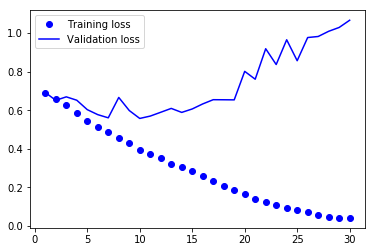

In [19]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()

> These plots are characteristic of overfitting. Our training accuracy increases linearly
over time, until it reaches nearly 100%, while our validation accuracy stalls at 70-72%.
Our validation loss reaches its minimum after only five epochs then stalls, while the
training loss keeps decreasing linearly until it reaches nearly 0.

上面两张图是很典型的过拟合情形。训练准确率随着迭代线性增长，直到接近100%，然而验证准确率停滞在70-72%之间。验证损失在仅在5次epochs迭代之后就达到了最小值，而训练损失随着迭代不断线性减少直到接近0。

> Because we only have relatively few training samples (2000), overfitting is going to
be our number one concern. You already know about a number of techniques that can
help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are
now going to introduce a new one, specific to computer vision, and used almost
universally when processing images with deep learning models: data augmentation .

因为我们只有相对较少的训练样本（2000个），过拟合将会是我们首要关注的问题。在前面我们已经介绍了一些技巧来避免过拟合，比方说dropout和权重衰减（正则化）。下面我们来介绍一个新的方法，特别针对计算机视觉，在使用深度学习模型进行图像处理时被广泛采用：数据增广。

### 5.2.5 使用数据增广

> Overfitting is caused by having too few samples to learn from, rendering us unable to
train a model able to generalize to new data. Given infinite data, our model would be
exposed to every possible aspect of the data distribution at hand: we would never overfit.
Data augmentation takes the approach of generating more training data from existing
training samples, by "augmenting" the samples via a number of random transformations
that yield believable-looking images. The goal is that at training time, our model would
never see the exact same picture twice. This helps the model get exposed to more aspects
of the data and generalize better.

过拟合经常由于能够用于学习的样本数量太少导致，其结果就是无法训练出一个能够很好的在新数据上泛化的模型，如果模型能够暴露在数据分布上每种可能的情况下进行训练的话：过拟合将不会发生。数据增广使用了一种从已存在训练样本中产生更多训练数据的方法，通过一系列随机图像转换的方式来获得看起来可信的新图像。目标是在训练阶段，模型永远不会看到相同的图像两次或以上。这能帮助模型被暴露在数据分布的更多情况之下，使得它能更好的泛化。

> In Keras, this can be done by configuring a number of random transformations to be
performed on the images read by our ImageDataGenerator instance. Let’s get started
with an example:

在Keras中，这能通过在创建`ImageDataGenerator`实例时，配置一些随机图像转换的参数来实现。下面通过一个例子开始说明：

In [20]:
datagen = ImageDataGenerator(rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

> These are just a few of the options available (for more, see the Keras documentation).
Let’s quickly go over what we just wrote:

> - rotation_range is a value in degrees (0-180), a range within which to randomly rotate
pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height)
within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.
- horizontal_flip is for randomly flipping half of the images horizontally—relevant
when there are no assumptions of horizontal asymmetry (e.g. real-world pictures).
- fill_mode is the strategy used for filling in newly created pixels, which can appear after
a rotation or a width/height shift.

上面例子中仅列出了数个参数（参见Keras文档查看全部）。下面快速过一遍这些参数：

- `rotation_range`是一个（0-180）的值，代表随机旋转图像的角度。
- `width_shift`和`height_shift`在水平和垂直方向随机平移图像的比例（占总宽度和高度的比例）范围。
- `shear_range`定义随机剪切变换的比例范围。
- `zoom_range`定义图像中随机放大的比例范围。
- `horizontal_flip`用来对图像进行做水平翻转，并且图像上没有水平对称性的假设（比方说真实世界的图像）。
- `fill_mode`指定当图像出现新像素点时填充的策略，新的像素点可以在旋转或者平移后出现。

> Let’s take a look at our augmented images:

然后我们来看看这些增广的图像：

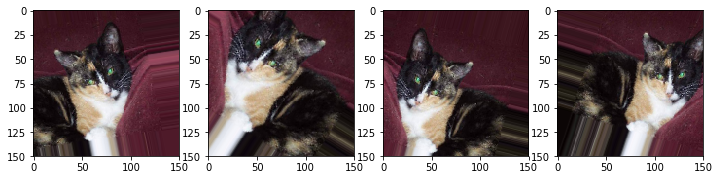

In [21]:
# 载入Keras的图像预处理模块
from tensorflow.keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]
# 随便选择一张照片进行增广
img_path = fnames[3]

# 读取图像，改变大小
img = image.load_img(img_path, target_size=(150, 150))
# 转换成一个形状为(150, 150, 3)的Numpy数组
x = image.img_to_array(img)
# 变形为(1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# 下面使用ImageDataGenerator的flow方法，无限的产生新的图像，我们在产生了4张图像后就跳出无限循环
i = 0
plt.figure(figsize=(12, 3))
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(1, 4, i + 1)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

> If we train a new network using this data augmentation configuration, our network
will never see twice the same input. However, the inputs that it sees are still heavily
intercorrelated, since they come from a small number of original images—we cannot
produce new information, we can only remix existing information. As such, this might
not be quite enough to completely get rid of overfitting. To further fight overfitting, we
will also add a Dropout layer to our model, right before the densely-connected classifier:

如果我们使用这样的数据增广配置来训练新模型的话，网络不会碰到相同输入两次以上。然而这些输入仍然是高度相关的，因为它们还是来自于一个小规模的原始图像数据集 - 我们无法从中产生新的信息，我们只能将已有的信息重新编排。正因为此这种方法不足以完全消除过拟合。为了进一步对抗过拟合，我们还需要在模型中加入Dropout层，将其加到全连接分类器之前：

In [22]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=1e-4),
            metrics=['acc'])

> Let’s train our network using data augmentation and dropout:

然后使用数据增广和dropout来重新训练网络：

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
# 请注意验证数据不应该进行增广操作
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')
test_generator = test_datagen.flow_from_directory(validation_dir,
                                                 target_size=(150, 150),
                                                 batch_size=20,
                                                 class_mode='binary')
history = model.fit(train_generator, steps_per_epoch=100, epochs=100,
                   validation_data=test_generator, validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/100
100/100 [==============================] - 29s 285ms/step - loss: 0.6893 - acc: 0.5370 - val_loss: 0.6998 - val_acc: 0.5000
Epoch 2/100
100/100 [==============================] - 28s 276ms/step - loss: 0.6774 - acc: 0.5665 - val_loss: 0.6703 - val_acc: 0.5480
Epoch 3/100
100/100 [==============================] - 30s 298ms/step - loss: 0.6634 - acc: 0.5915 - val_loss: 0.6736 - val_acc: 0.5590
Epoch 4/100
100/100 [==============================] - 30s 299ms/step - loss: 0.6477 - acc: 0.6190 - val_loss: 0.6557 - val_acc: 0.5900
Epoch 5/100
100/100 [==============================] - 29s 291ms/step - loss: 0.6332 - acc: 0.6420 - val_loss: 0.6436 - val_acc: 0.6270
Epoch 6/100
100/100 [==============================] - 29s 292ms/step - loss: 0.6205 - acc: 0.6475 - val_loss: 0.6053 - val_acc: 0.6560
Epoch 7

Epoch 59/100
100/100 [==============================] - 29s 289ms/step - loss: 0.4563 - acc: 0.7805 - val_loss: 0.4544 - val_acc: 0.7900
Epoch 60/100
100/100 [==============================] - 29s 289ms/step - loss: 0.4335 - acc: 0.8040 - val_loss: 0.4527 - val_acc: 0.8010
Epoch 61/100
100/100 [==============================] - 29s 287ms/step - loss: 0.4495 - acc: 0.7880 - val_loss: 0.4831 - val_acc: 0.7720
Epoch 62/100
100/100 [==============================] - 28s 284ms/step - loss: 0.4332 - acc: 0.7910 - val_loss: 0.4901 - val_acc: 0.7760
Epoch 63/100
100/100 [==============================] - 29s 285ms/step - loss: 0.4369 - acc: 0.7995 - val_loss: 0.4534 - val_acc: 0.7840
Epoch 64/100
100/100 [==============================] - 29s 286ms/step - loss: 0.4310 - acc: 0.8040 - val_loss: 0.4523 - val_acc: 0.8030
Epoch 65/100
100/100 [==============================] - 29s 286ms/step - loss: 0.4182 - acc: 0.7970 - val_loss: 0.4623 - val_acc: 0.7900
Epoch 66/100
100/100 [===================

> Let’s save our model—we will be using it in the section on convnet visualization.

让我们保存这个模型 - 我们会在可视化卷积网络一节中再次使用它。

In [24]:
model.save('models/chapter5/cats_and_dogs_small_2.h5')

> Let’s plot our results again:

然后再把训练结果可视化成图表：

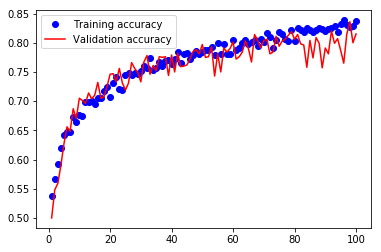

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
plt.legend()

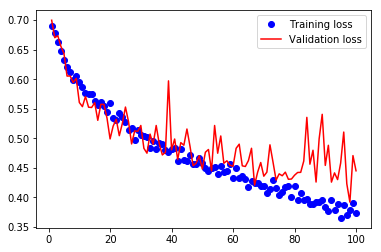

In [26]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.legend()

> Thanks to data augmentation and dropout, we are no longer overfitting: the training
curves are rather closely tracking the validation curves. We are now able to reach an
accuracy of 82%, a 15% relative improvement over the non-regularized model.

得力于数据增广和dropout层技术，模型已经不会过拟合了：训练曲线与验证曲线基本上重合。我们可以达到月82%的准确率，比之前的未采取正则化的模型相对提高了15%的准确率。

> By leveraging regularization techniques even further and by tuning the network’s
parameters (such as the number of filters per convolution layer, or the number of layers
in the network), we may be able to get an even better accuracy, likely up to 86-87%.
However, it would prove very difficult to go any higher just by training our own convnet
from scratch, simply because we have so little data to work with. As a next step to
improve our accuracy on this problem, we will have to leverage a pre-trained model,
which will be the focus of the next two sections.

我们还能进一步深入调整网络参数和提升正则化技巧（例如调整每个卷积层的过滤器数量或者网络中层数量），这样还能继续提升准确率，大致能达到86-87%左右。然而，要想使用这个我们从头搭建的卷积网络来进一步提升准确率却非常困难了，因为我们可用的数据太少了。作为这个问题上下一个改善准确率的方法，我们将会引入预训练模型，这将是接下来两小节的重点。

## 5.3 使用预训练卷积网络

> A common and highly effective approach to deep learning on small image datasets is to
leverage a pre-trained network. A pre-trained network is simply a saved network
previously trained on a large dataset, typically on a large-scale image classification task.
If this original dataset is large enough and general enough, then the spatial feature
hierarchy learned by the pre-trained network can effectively act as a generic model of our
visual world, and hence its features can prove useful for many different computer vision
problems, even though these new problems might involve completely different classes
from those of the original task. For instance, one might train a network on ImageNet
(where classes are mostly animals and everyday objects) and then re-purpose this trained
network for something as remote as identifying furniture items in images. Such
portability of learned features across different problems is a key advantage of deep
learning compared to many older shallow learning approaches, and it makes deep
learning very effective for small-data problems.

在小型数据集上进行深度学习训练的一个常见而有效的方法是使用预训练网络。预训练网络简单来说就是一个在大型数据集上预先训练好保存下来的网络模型，典型情况就是在大规模图像分类任务上。如果原始的数据集足够大和通用，那么预训练网络学习到的空间特征层次可以作为视觉领域的一个通用模型，因此它的特征可以被用在许多不同的计算机视觉问题上，即使这些新的问题包含着与原始任务完全不同分类的情况下。例如我们可以在ImageNet数据集上训练一个模型（ImageNet数据集上的图像多数是动物和日常物品），然后再将这个模型重用到类似识别图像中的家具物品这么完全不同的问题之上。这种在不同问题上的可重用性是深度学习与很多传统浅学习方法对比的关键优势，它使得深度学习对于小型数据问题非常高效。

> In our case, we will consider a large convnet trained on the ImageNet dataset (1.4
million labeled images and 1000 different classes). ImageNet contains many animal
classes, including different species of cats and dogs, and we can thus expect to perform
very well on our cat vs. dog classification problem.

在我们的例子中，我们将考虑使用一个在ImageNet数据集（1400万标记图像，涵盖1000个不同分类）训练好的卷积网络。ImageNet数据集中有许多动物分类，包括不同种类的猫和狗，因此我们期望它应该能在猫狗分类问题上表现良好。

> We will use the VGG16 architecture, developed by Karen Simonyan and Andrew
Zisserman in 2014, a simple and widely used convnet architecture for ImageNet.
Although it is a bit of an older model, far from the current state of the art and somewhat
heavier than many other recent models, we chose it because its architecture is similar to
what you are already familiar with, and easy to understand without introducing any new
concepts. This may be your first encounter with one of these cutesie model
names—VGG, ResNet, Inception, Inception-ResNet, Xception... you will get used to
them, as they will come up frequently if you keep doing deep learning for computer
vision.

我们将选择使用`VGG16`结构，它是在2014年被Karen Simonyan和Andrew Zisserman发明的，是一个在ImageNet上简单且广泛被使用的卷积网络结构。虽然它已经是一个较老的模型，比较现代的一些模型显得较重，我们选择它的原因在于它的结构与我们已经熟悉的内容很接近，在无需介绍新的概念的情况下也能容易被理解。这将是你第一次碰到这种可爱的模型名称 - VGG，ResNet，Inception-ResNet，Xception等等。当你在计算机视觉上不断进行实验之后你会逐渐熟悉这些名字。

> There are two ways to leverage a pre-trained network: feature extraction and
fine-tuning . We will cover both of them. Let’s start with feature extraction.

引入预训练网络有两种方式：特征提取和精细调参。我们会一一介绍。首先从特征提取开始。

### 5.3.1 特征提取

> Feature extraction consists of using the representations learned by a previous network to
extract interesting features from new samples. These features are then run through a new
classifier, which is trained from scratch.

特征提取的含义是在训练好的网络上从新样本中提取感兴趣的特征出来。这些特征然后被导入到一个新的分类器中，这个分类器是从头开始构建的。

> As we saw previously, convnets used for image classification comprise two parts:
they start with a series of pooling and convolution layers, and they end with a
densely-connected classifier. The first part is called the "convolutional base" of the
model. In the case of convnets, "feature extraction" will simply consist of taking the
convolutional base of a previously-trained network, running the new data through it, and
training a new classifier on top of the output.

前面看到过，卷积网络用来进行图像分类主要分成两大部分：它们首先是一系列的卷积层和池化层，然后是一个全连接的分类器。这里的第一部分被称为模型的“卷积基”。在卷积网络中，“特征提取”意味着我们仅使用预训练网络的卷积基，然后在其上构建一个新的分类器，合成一个完整的网络，然后输入新的数据。

![feature extraction](imgs/f5.14.jpg)

图5-14 使用新的分类器替换预训练模型的分类器，保留卷积基

> Why only reuse the convolutional base? Could we reuse the densely-connected
classifier as well? In general, it should be avoided. The reason is simply that the
representations learned by the convolutional base are likely to be more generic and
therefore more reusable: the feature maps of a convnet are presence maps of generic
concepts over a picture, which is likely to be useful regardless of the computer vision
problem at hand. On the other end, the representations learned by the classifier will
necessarily be very specific to the set of classes that the model was trained on—they will
only contain information about the presence probability of this or that class in the entire
picture. Additionally, representations found in densely-connected layers no longer
contain any information about where objects are located in the input image: these layers
get rid of the notion of space, whereas the object location is still described by
convolutional feature maps. For problems where object location matters,
densely-connected features would be largely useless.

为什么只复用卷积基呢？是否也能够复用全连接分类器呢？通常来说，答案是否定的。简单来解释的话那就是卷积基学习到的表现形式是更加泛化和可复用的：卷积网络的特征地图是一张图片上的通用特征，因此可以认为是与手头的计算机视觉问题无关的。另一方面，分类器学习到的表现形式基本上可以肯定与特定的问题以及分类相关 - 它们仅仅包括整张图像分成不同类别的概率。并且，在全连接层中的表现形式已经不包含任何输入图像中的对象的位置信息：这些层已经清除了空间的概念，而在卷积的特征地图中其实仍然保留着对象位置的信息。对于对象位置相关的问题来说，全连接的特征是基本没有作用的。

> Note that the level of generality (and therefore reusability) of the representations
extracted by specific convolution layers depends on the depth of the layer in the model.
Layers that come earlier in the model extract local, highly generic feature maps (such as
visual edges, colors, and textures), while layers higher-up extract more abstract concepts
(such as "cat ear" or "dog eye"). So if your new dataset differs a lot from the dataset that
the original model was trained on, you may be better off using only the first few layers of
the model to do feature extraction, rather than using the entire convolutional base.

注意特定卷积层提取的表现形式泛化能力的高低（也代表这可复用能力）依赖于模型层的深度。模型中前面的层只能提取局部的高度特定的特征地图（例如可见的边缘，颜色和纹理），而位置较高的层次能够提取更加抽象的概念（例如“猫耳朵”或者“狗眼睛”）。因此如果你的新数据集与模型训练使用的原始数据集有巨大差别的话，最好使用那些模型中前面的层次来进行特征提取，而不是使用整个卷积基。

> In our case, since the ImageNet class set did contain multiple dog and cat classes, it is
likely that it would be beneficial to reuse the information contained in the
densely-connected layers of the original model. However, we will chose not to, in order
to cover the more general case where the class set of the new problem does not overlap
with the class set of the original model.

在我们自己的例子中，因为ImageNet的分类类别中并不包含多种狗和猫的类别，似乎复用模型全连接层的信息也有优势。然而我们不打算这么做，因为这样能覆盖更加广泛的情形，特别是新问题的分类与原始模型的分类没有任何重叠的情况。

> Let’s put this in practice by using the convolutional base of the VGG16 network,
trained on ImageNet, to extract interesting features from our cat and dog images, and
then training a cat vs. dog classifier on top of these features.

下面在实际例子中来使用VGG16网络的卷积基，这个模型是在ImageNet数据集上进行的预训练，用来在猫和狗的图像中提取感兴趣的特征，然后再其上构建一个猫狗的分类器来进行训练。

> The VGG16 model, among others, comes pre-packaged with Keras. You can import
it from the keras.applications module. Here’s the list of image classification models
(all pre-trained on the ImageNet dataset) that are available as part of
keras.applications :

VGG16还有其他的一些预训练模型，都是预装在Keras当中的。你可以在`keras.application`模块中引入它。下面是部分你能在`keras.application`包中找到的图像分类预训练模型（都是在ImageNet数据集上训练得到的）：

- Xception
- InceptionV3
- ResNet50
- VGG16
- VGG19
- MobileNet

> Let’s instantiate the VGG16 model:

然后实例化一个VGG16模型：

In [27]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

> We passed three arguments to the constructor:

> - weights , to specify which weight checkpoint to initialize the model from
- include_top , which refers to including or not the densely-connected classifier on top of
the network. By default, this densely-connected classifier would correspond to the 1000
classes from ImageNet. Since we intend to use our own densely-connected classifier
(with only two classes, cat and dog), we don’t need to include it.
- input_shape , the shape of the image tensors that we will feed to the network. This
argument is purely optional: if we don’t pass it, then the network will be able to process
inputs of any size.

上面传递了三个参数给构造器：

- 权重`weights`，指定模型中权重参数初始化的点
- 是否包括分类器`include_top`，指定是否在网络上层包括全连接的分类器。默认情况下这个全连接分类型会从ImageNet中分出相应的1000中类别出来。因为我们希望使用自己的全连接分类器（只有两个类别，猫和狗），我们不需要包括它。
- 输入形状`input_shape`，输入到网络中的图像张量形状。这个参数是可选的，如果没有传递它，那么网络能够处理任何尺寸的输入。

> Here’s the detail of the architecture of the VGG16 convolutional base: it’s very
similar to the simple convnets that you are already familiar with.

然后我们来看看VGG16卷积基的结构：它非常接近与你已经熟悉的简单的卷积网络。

In [28]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

> The final feature map has shape (4, 4, 512) . That’s the feature on top of which we
will stick a densely-connected classifier.

最后的特征地图形状为(4, 4, 512)。这个顶层的特征之上就是我们构建全连接分类器的地方。

> At this point, there are two ways we could proceed:

> - Running the convolutional base over our dataset, recording its output to a Numpy array
on disk, then using this data as input to a standalone densely-connected classifier similar
to those you have seen in the first chapters of this book. This solution is very fast and
cheap to run, because it only requires running the convolutional base once for every input
image, and the convolutional base is by far the most expensive part of the pipeline.
However, for the exact same reason, this technique would not allow us to leverage data
augmentation at all.
- Extending the model we have ( conv_base ) by adding Dense layers on top, and running
the whole thing end-to-end on the input data. This allows us to use data augmentation,
because every input image is going through the convolutional base every time it is seen
by the model. However, for this same reason, this technique is far more expensive than
the first one.

在这一步，有两个方法我们可以选择：

- 在数据集上运行这个卷积基，保存它的输出Numpy数组到磁盘，然后将这些保存的数据作为一个独立的全连接分类器的输入，就像本书第一章介绍的那种分类器那样。这个方法运行速度很快，资源占用低，因为它仅需要在每个输入图像上运行一次卷积基，而卷积基是目前整个机器学习管道上最昂贵的部分。但是这样做的缺点是，这个方法不允许我们采用数据增广技术。
- 在目前的模型（`conv_base`）的基础上扩展，在上面增加全连接层，然后将输入数据完整的通过卷积基和分类器组成的管道。这允许我们进行数据增广，因为每张输入图像都会多次经过卷积基。但是，你也猜到了，这个方法比第一个方法要昂贵许多。

> We will cover both techniques. Let’s walk through the code required to set-up the
first one: recording the output of conv_base on our data and using these outputs as
inputs to a new model.

这里我们会介绍全部两种方法。首先展示使用第一种方法所需要的代码：将`conv_base`在我们数据上的输出保存下来，然后使用这些输出作为新模型的输入。

> We will start by simply running instances of the previously-introduced
ImageDataGenerator to extract images as Numpy arrays as well as their labels. We will
extract features from these images simply by calling the predict method of the
conv_base model.

我们首先会使用前面引入的`ImageDataGenerator`来产生图像的Numpy数组和它们的标签。然后使用`conv_base`模型的`predict`方法来提取这些图像的特征。

In [29]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/wangy/data/catsvsdogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
                        directory,
                        target_size=(150, 150),
                        batch_size=batch_size,
                        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        # 填充该批次的图像特征地图和标签向量
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
        # 当所有图像都过了一遍卷积基后，跳出循环，返回结果
            break
    return features, labels
# 分别提取训练、验证和测试的特征
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


> The extracted features are currently of shape (samples, 4, 4, 512) . We will feed
them to a densely-connected classifier, so first we must flatten them to (samples,
8192) :

上面提取出来的特征的形状是(samples, 4, 4, 512)。我们后面会将它们导入到一个全连接分类器中，因此首先我们将它们形状转换为(samples, 8192)：

In [30]:
train_features = train_features.reshape(2000, 4 * 4 * 512)
validation_features = validation_features.reshape(1000, 4 * 4 * 512)
test_features = test_features.reshape(1000, 4 * 4 * 512)

> At this point, we can define our densely-connected classifier (note the use of dropout
for regularization), and train it on the data and labels that we just recorded:

到这一步就可以定义我们自己的全连接分类器了（注意这里使用了dropout层来正则化），最后在使用刚才获得的输出数据来训练它：

In [31]:
from tensorflow.keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss='binary_crossentropy',
             metrics=['acc'])

In [32]:
history = model.fit(train_features, train_labels, epochs=30, batch_size=20,
                   validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 863us/sample - loss: 0.4519 - acc: 0.7830 - val_loss: 0.3051 - val_acc: 0.8780
Epoch 2/30
2000/2000 [==============================] - 1s 679us/sample - loss: 0.2975 - acc: 0.8795 - val_loss: 0.2551 - val_acc: 0.9010
Epoch 3/30
2000/2000 [==============================] - 1s 682us/sample - loss: 0.2458 - acc: 0.8985 - val_loss: 0.2594 - val_acc: 0.8920
Epoch 4/30
2000/2000 [==============================] - 1s 679us/sample - loss: 0.2059 - acc: 0.9195 - val_loss: 0.2445 - val_acc: 0.9030
Epoch 5/30
2000/2000 [==============================] - 1s 663us/sample - loss: 0.1874 - acc: 0.9275 - val_loss: 0.2379 - val_acc: 0.9000
Epoch 6/30
2000/2000 [==============================] - 1s 675us/sample - loss: 0.1576 - acc: 0.9395 - val_loss: 0.2542 - val_acc: 0.9000
Epoch 7/30
2000/2000 [==============================] - 1s 725us/sample - loss: 0.1357 - acc: 0.9505 - val_loss: 0.2533 - va

> Training is very fast, since we only have to deal with two Dense layers—an epoch
takes less than one second even on CPU.

训练过程非常快速，因为我们只需要处理两个全连接层 - 即使在CPU上每次epoch迭代仅需不到一秒。

> Let’s take a look at the loss and accuracy curves during training:

然后再来看看训练过程中的损失和准确率曲线：

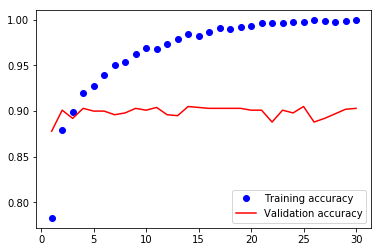

In [33]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
plt.legend()

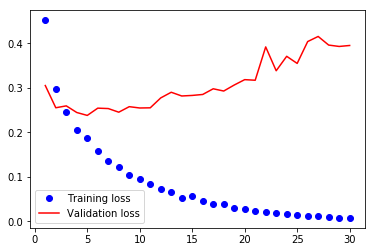

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.legend()

> We reach a validation accuracy of about 90%, much better than what we could
achieve in the previous section with our small model trained from scratch. However, our
plots also indicate that we are overfitting almost from the start—despite using dropout
with a fairly large rate. This is because this technique does not leverage data
augmentation, which is essential to preventing overfitting with small image datasets.

我们获得了验证准确率大概是90%，明显优于上一节我们训练的那个从头搭建的小型模型。然而上面的图显式模型从一开始就出现了过拟合 - 即使在使用了一个较大比例的dropout层的情况下。这是因为这个方法无法应用数据增广技术，这在小型数据集上防止过拟合的效果是非常明显的。

> Now, let’s review the second technique we mentioned for doing feature extraction,
which is much slower and more expensive, but which allows us to leverage data
augmentation during training: extending the conv_base model and running it end-to-end
on the inputs. Note that this technique is in fact so expensive that you should only
attempt it if you have access to a GPU: it is absolutely intractable on CPU. If you cannot
run your code on GPU, then the previous technique is the way to go.

下面来看一下前面提到的第二种特征提取的方法，这个方法慢许多而且非常昂贵，但是它允许我们在训练时采用数据增广技术：这个方法就是扩展`conv_base`模型然后将输入从头到尾在网络上进行训练。注意这个技巧事实上非常昂贵因此你应该仅在你可以使用GPU的情况下使用它：在CPU上运行它是很困难的。如果你不能在GPU上运行，那么你应该采用前面一种方法。

> Because models behave just like layers, you can add a model (like our conv_base ) to
a Sequential model just like you would add a layer. So you can do the following:

因为模型的行为与层基本一致，因此你可以将一个模型（例如`conv_base`）加入到一个`Sequential`模型中，就好像加入一层那样。因此下面的做法就是构建扩展的模型代码：

In [35]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

> This is what our model looks like now:

完整的模型看起来如下：

In [36]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


> As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which
is very large. The classifier we are adding on top has 2 million parameters.

上面看到，VGG16的卷积基有着14,714,688个参数，这是非常巨大的。我们增加的分类器有200万个参数。



In [37]:
print('This is the number of trainable weights '
'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [38]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(150, 150),
                    batch_size=20,
                    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
                    validation_dir,
                    target_size=(150, 150),
                    batch_size=20,
                    class_mode='binary')
model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=2e-5),
            metrics=['acc'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [39]:
history = model.fit_generator(
                    train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/30
100/100 [==============================] - 100s 1s/step - loss: 0.6810 - acc: 0.6070 - val_loss: 0.4979 - val_acc: 0.8060
Epoch 2/30
100/100 [==============================] - 101s 1s/step - loss: 0.5756 - acc: 0.6940 - val_loss: 0.4252 - val_acc: 0.8360
Epoch 3/30
100/100 [==============================] - 103s 1s/step - loss: 0.5092 - acc: 0.7500 - val_loss: 0.3794 - val_acc: 0.8560
Epoch 4/30
100/100 [==============================] - 102s 1s/step - loss: 0.4671 - acc: 0.7715 - val_loss: 0.3502 - val_acc: 0.8610
Epoch 5/30
100/100 [==============================] - 102s 1s/step - loss: 0.4585 - acc: 0.7885 - val_loss: 0.3294 - val_acc: 0.8770
Epoch 6/30
100/100 [==============================] - 103s 1s/step - loss: 0.4355 - acc: 0.7900 - val_loss: 0.3225 - val_acc: 0.8740
Epoch 7/30
100/100 [==============================] - 101s 1s/step - loss: 0.4288 - acc: 0.7935 - val_loss: 0

> Let’s plot our results again:

再次绘制结果：

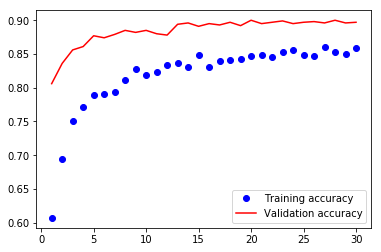

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
plt.legend()

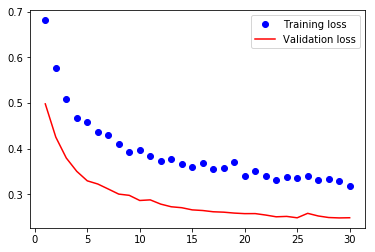

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.legend()

> As you can see, we reach a validation accuracy of about 96%. This is much better
than our small convnet trained from scratch.

可以看到达到了大约96%的验证准确率。这比我们从头开始构建的卷积网络好了许多。

译者注：译者机器上训练的最高验证准确率仍然是90%左右，上面是原文照译。从结果上看，还未出现过拟合，因此，进行更多次的迭代可能会获得更好的性能。

### 5.3.2 精细调参

> Another widely used technique for model reuse, complementary to feature extraction, is
fine-tuning . Fine-tuning consists in unfreezing a few of the top layers of a frozen model
base used for feature extraction, and jointly training both the newly added part of the
model (in our case, the fully-connected classifier) and these top layers. This is called
"fine-tuning" because it slightly adjusts the more abstract representations of the model
being reused, in order to make them more relevant for the problem at hand.

另一个广泛使用的模型复用技巧，作为特征提取的补充，叫做精细调参。精细调参包括着模型顶部的一部分可训练层以及底部的一些冻结的不可训练的特征提取层组成，然后使用这些顶部的可训练层与我们增加的层次（本例中将是全连接分类器）联合起来进行训练。被称为“精细调参”的原因是因为复用的模型当中部分的抽象表现形式会在过程中得到一些精细调整，使得它们更加适合我们遇到的问题。

![fine tuning](imgs/f5.19.jpg)

图5-19 对VGG16模型最后一部分卷积层进行精细调参

> We have stated before that it was necessary to freeze the convolution base of VGG16
in order to be able to train a randomly initialized classifier on top. For the same reason, it
is only possible to fine-tune the top layers of the convolutional base once the classifier on
top has already been trained. If the classified wasn’t already trained, then the error signal
propagating through the network during training would be too large, and the
representations previously learned by the layers being fine-tuned would be destroyed.
Thus the steps for fine-tuning a network are as follow:

> - 1) Add your custom network on top of an already trained base network.
- 2) Freeze the base network.
- 3) Train the part you added.
- 4) Unfreeze some layers in the base network.
- 5) Jointly train both these layers and the part you added.

前面我们说过需要将VGG16的卷积基部分冻结起来不参与训练，这样才能在之上训练得到一个随机初始化的分类器。处于相同的而原因，只有当顶层的分类器已经训练好了之后才有可能精细调整复用模型卷积基的部分层次。如果分类器还未被训练，那么传播到网络中的错误反馈信号就会很大，会导致原来已经训练好的那些层次的参数发生严重偏离。因此精细调整网络的步骤如下：

- 1) 在预训练网络上增加你自己的网络。
- 2) 冻结基本网络，使其不可训练。
- 3) 训练你增加的部分网络。
- 4) 解冻基本网络的部分层次。
- 5) 联合训练这些层次和你增加的网络部分。

> We have already completed the first 3 steps when doing feature extraction. Let’s
proceed with the 4th step: we will unfreeze our conv_base , and then freeze individual
layers inside of it.

在前面的特征提取中我们已经完成了前三步了。下面可以开始进行第四步：解冻`conv_base`，然后冻结其中底部的那些层次。

> As a reminder, this is what our convolutional base looks like:

下面重新列出卷积基的结构方便回忆：

In [42]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

> We will fine-tune the last 3 convolutional layers, which means that all layers up until
block4_pool should be frozen, and the layers block5_conv1 , block5_conv2 and
block5_conv3 should be trainable.

我们会精细调整最后三个卷积层，这意味着所有直到`block4_pool`的层次都将被冻结，而`block5_conv1`、`block5_conv2`和`block5_conv3`将变为可训练的。

> Why not fine-tune more layers? Why not fine-tune the entire convolutional base? We
could. However, we need to consider that:

> - Earlier layers in the convolutional base encode more generic, reusable features, while
layers higher up encode more specialized features. It is more useful to fine-tune the more
specialized features, as these are the ones that need to be repurposed on our new problem.
There would be fast-decreasing returns in fine-tuning lower layers.
- The more parameters we are training, the more we are at risk of overfitting. The
convolutional base has 15M parameters, so it would be risky to attempt to train it on our
small dataset.

为什么不精细调整更多的层？为什么不精细调整整个卷积基？我们可以这样做。然而我们必须考虑到以下两点：

- 卷积基的前面层次提取的都是更加通用和可复用的特征，而随着层次升高，它们将会提取到更加特定的特征。因此精细调整这些更加特定的特征会更加有帮助，因为这些都是需要根据我们新的问题进行重新适配的特征。但是对于底层的精细调整带来的却是快速下降的回报。
- 模型中参与训练的参数越多，就越容易导致过拟合。例子中的卷积核有着1500万个参数，因此用它们全部都参与到小型数据集上的训练风险是非常高的。

> Thus, in our situation, it is a good strategy to only fine-tune the top 2 to 3 layers in the
convolutional base.

因此在我们的情况中，仅仅调整卷积基最顶的2到3层会是一个很好的策略。

> Let’s set this up, starting from where we left off in the previous example:

下面我们从上一个例子的结构开始进行下面的实验：

In [43]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

> Now we can start fine-tuning our network. We will do this with the RMSprop
optimizer, using a very low learning rate. The reason for using a low learning rate is that
we want to limit the magnitude of the modifications we make to the representations of
the 3 layers that we are fine-tuning. Updates that are too large may harm these
representations.

现在我们可以开始精细调整我们网络的参数了。下面会使用一个非常慢的学习率的RMSprop优化器来进行训练。使用低学习率的原因是我们希望能够限制进行精细调整的三个层次的参数变化量。如果参数调整过大可能会损害这些层的表现形式。

> Now let’s proceed with fine-tuning:

然后我们开始精细调整的训练过程：

In [44]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(train_generator, steps_per_epoch=100, epochs=100,
         validation_data=validation_generator, validation_steps=50)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/100
100/100 [==============================] - 114s 1s/step - loss: 0.3264 - acc: 0.8585 - val_loss: 0.2259 - val_acc: 0.9080
Epoch 2/100
100/100 [==============================] - 119s 1s/step - loss: 0.2850 - acc: 0.8785 - val_loss: 0.2134 - val_acc: 0.9150
Epoch 3/100
100/100 [==============================] - 121s 1s/step - loss: 0.2706 - acc: 0.8740 - val_loss: 0.2056 - val_acc: 0.9160
Epoch 4/100
100/100 [==============================] - 121s 1s/step - loss: 0.2260 - acc: 0.9055 - val_loss: 0.2010 - val_acc: 0.9190
Epoch 5/100
100/100 [==============================] - 120s 1s/step - loss: 0.2272 - acc: 0.9010 - val_loss: 0.2130 - val_acc: 0.9140
Epoch 6/100
100/100 [==============================] - 120s 1s/step - loss: 0.2090 - acc: 0.9120 - val_loss: 0.2069 - val_acc: 0.9150
Epoch 7/100
100/100 [==============================] - 119s 1s/step - loss: 0.1956 - acc: 0.9260 - val_

100/100 [==============================] - 118s 1s/step - loss: 0.0337 - acc: 0.9875 - val_loss: 0.2373 - val_acc: 0.9410
Epoch 61/100
100/100 [==============================] - 118s 1s/step - loss: 0.0361 - acc: 0.9855 - val_loss: 0.2556 - val_acc: 0.9350
Epoch 62/100
100/100 [==============================] - 120s 1s/step - loss: 0.0494 - acc: 0.9820 - val_loss: 0.2297 - val_acc: 0.9350
Epoch 63/100
100/100 [==============================] - 120s 1s/step - loss: 0.0362 - acc: 0.9860 - val_loss: 0.2064 - val_acc: 0.9380
Epoch 64/100
100/100 [==============================] - 118s 1s/step - loss: 0.0415 - acc: 0.9875 - val_loss: 0.2671 - val_acc: 0.9310
Epoch 65/100
100/100 [==============================] - 119s 1s/step - loss: 0.0399 - acc: 0.9890 - val_loss: 0.5781 - val_acc: 0.8980
Epoch 66/100
100/100 [==============================] - 119s 1s/step - loss: 0.0463 - acc: 0.9855 - val_loss: 0.2190 - val_acc: 0.9380
Epoch 67/100
100/100 [==============================] - 119s 1s/step

> Let’s plot our results using the same plotting code as before:

然后用同样的代码将结果可视化出来：

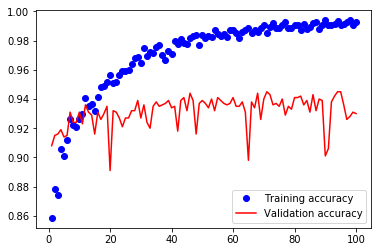

In [45]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
plt.legend()

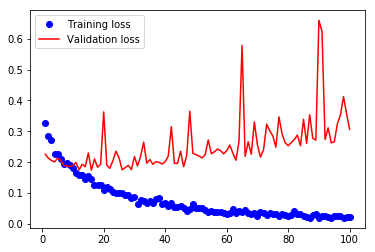

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.legend()

> These curves look very noisy. To make them more readable, we can smooth them by
replacing every loss and accuracy with exponential moving averages of these quantities.
Here’s a trivial utility function to do this:

这些曲线看起来很杂乱。为了使得更加容易看清楚，我们可以使用指数移动平均来更新每个数据点的损失值和准确率。下面的代码是实现的工具函数：

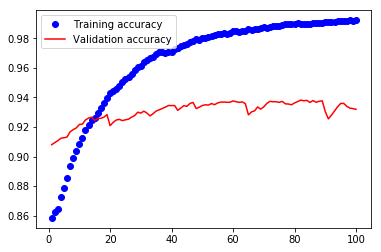

In [47]:
def smooth_curve(points, factor=.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Training accuracy')
plt.plot(epochs, smooth_curve(val_acc), 'r-', label='Validation accuracy')
plt.legend()

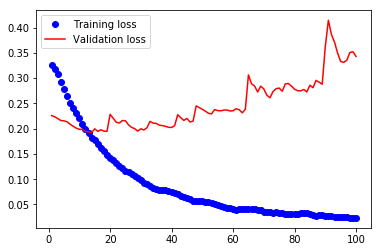

In [48]:
plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'r-', label='Validation loss')
plt.legend()

> These curves look much cleaner and more stable. We are seeing a nice 1% absolute
improvement.

上面的曲线看起来更加清晰和稳定。可以看到1%准确率的绝对提升。

译者注：译者机器跑出来的结果可以达到将近4%准确率的绝对提升。

> Note that the loss curve does not show any real improvement (in fact, it is
deteriorating). You may wonder, how could accuracy improve if the loss isn’t
decreasing? The answer is simple: what we display is an average of pointwise loss
values, but what actually matters for accuracy is the distribution of the loss values, not
their average, since accuracy is the result of a binary thresholding of the class probability
predicted by the model. The model may still be improving even if this isn’t reflected in
the average loss.

值得注意的是损失曲线并没有表现出任何实际的改善（事实上损失曲线还恶化了）。你可能会疑惑，如果损失没有下降为何准确率提升了呢？答案很简单：图中展示的是每个点的损失平均值，而实际上影响准确率的是损失值的分布情况，不是平均值，因为准确率是模型预测的分类概率的二分阈值结果。即使平均损失上没有表现出改善，模型的性能依然能够得到提升。

> We can now finally evaluate this model on the test data:

最后在测试集上验证模型：

In [49]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=(150, 150),
                                                 batch_size=20,
                                                 class_mode='binary')

model.evaluate(test_generator, steps=50)

Found 1000 images belonging to 2 classes.
  ...
    to  
  ['...']
50/50 [==============================] - 28s 567ms/step - loss: 0.3701 - acc: 0.9320


[0.37007514948294556, 0.932]

> Here we get a test accuracy of 97%. In the original Kaggle competition around this
dataset, this would have been one of the top results. However, using modern deep
learning techniques, we managed to reach this result using only a very small fraction of
the training data available (about 10%). There is a huge difference between being able to
train on 20,000 samples compared to 2,000 samples!

这样获得的测试准确率是97%。在当时Kaggle的这项竞赛中，这可以是顶尖结果了。然而，使用现代深度学习技巧，我们实现了在数据集中的一小部分数据上（大约10%）训练就完成了这个目标。这对于使用2000个样本和使用20000个样本进行训练是有着巨大区别的！

### 5.3.3 打包知识点：在小数据集上使用卷积网络

> Here’s what you should take away from the exercises of these past two sections:

> - Convnets are the best type of machine learning models for computer vision tasks. It is
possible to train one from scratch even on a very small dataset, with decent results.
- On a small dataset, overfitting will be the main issue. Data augmentation is a powerful
way to fight overfitting when working with image data.
- It is easy to reuse an existing convnet on a new dataset, via feature extraction. This is a
very valuable technique for working with small image datasets.
- As a complement to feature extraction, one may use fine-tuning, which adapts to a new
problem some of the representations previously learned by an existing model. This
pushes performance a bit further.

下面是以上两个小节中你应该记住的一些重点：

- 卷积网络是处理计算机视觉任务的最好的机器学习模型类型。在一个很小的数据集上从头训练一个卷积神经网络是可行的的，并且能获得一个令人接受的结果。
- 在小型数据集上，过拟合是最主要的问题。数据增广技术是当你处理图像数据是一个对抗过拟合的强大方法。
- 在一个新的数据集上通过特征提取来复用预训练的卷积网络是很容易的。这在应对小型图像数据集上非常有用。
- 作为特征提取的补充，可以使用精细调参，它用来将预训练的网络中的部分表现形式对新问题进行适配。这能将模型性能进一步提升。

> Now you have a solid set of tools for dealing with image classification problems, in
particular with small datasets.

选择你已经有了一整套工具用来处理图像分类问题，特别是在小型数据集上。

## 5.4 可视化卷积网络学习过程

> It is often said that deep learning models are "black boxes", learning representations that
are difficult to extract and present in a human-readable form. While this is partially true
for certain types of deep learning models, it is definitely not true for convnets. The
representations learned by convnets are highly amenable to visualization, in large part
because they are representations of visual concepts . Since 2013, a wide array of
techniques have been developed for visualizing and interpreting these representations.
We won’t survey all of them, but we will cover three of the most accessible and useful
ones:

> - Visualizing intermediate convnet outputs ("intermediate activations"). This is useful to
understand how successive convnet layers transform their input, and to get a first idea of
the meaning of individual convnet filters.
- Visualizing convnets filters. This is useful to understand precisely what visual pattern or
concept each filter in a convnet is receptive to.
- Visualizing heatmaps of class activation in an image. This is useful to understand which
part of an image where identified as belonging to a given class, and thus allows to
localize objects in images.

深度学习模型经常被称为“黑盒子”，学习到的表现形式难以使用人类可理解的方式来提取和表达出来。虽然这在某些深度学习模型中是正确的，但是在卷积网络中这是不对的。卷积网络学习到的表现形式特别合适进行可视化，因为它们本身就是可视概念的表现形式。从2013年之后，一大批的技术被开发出来对卷积网络进行可视化。我们不会介绍全部，但是会涉及以下三个最容易获得及有用的方法：

- 可视化卷积网络中间输出（“中间激活”）。这对于理解连续的均价为两层如何转换它们的输入，以及对每个卷积过滤器的意义进行直观理解是很有帮助的。
- 可视化卷积网络过滤器。这对于精确理解每个过滤器接受的视觉模式或概念很有帮助。
- 可视化图像中分类激活的热力图。这对于理解图像中的哪个部分用来区分成给定的类别很有帮助，并且能在图像中定位目标。

> For the first method—activation visualization—we will use the small convnet that we
trained from scratch on the cat vs. dog classification problem two sections ago. For the
next two methods, we will use the VGG16 model that we introduced in the previous
section.

对于第一种方法 - 激活可视化 - 这里将使用前面两个小节我们从头训练的一个小型卷积网络作为例子。对于后面两种方法，我们会使用上一节引入的VGG16模型作为例子来进行介绍。

### 5.4.1 可视化中间激活

> Visualizing intermediate activations consists in displaying the feature maps that are
output by various convolution and pooling layers in a network, given a certain input (the
output of a layer is often called its "activation", the output of the activation function).
This gives a view into how an input is decomposed unto the different filters learned by
the network. These feature maps we want to visualize have 3 dimensions: width, height,
and depth (channels). Each channel encodes relatively independent features, so the
proper way to visualize these feature maps is by independently plotting the contents of
every channel, as a 2D image. Let’s start by loading the model that we saved in section
5.2:

可视化中间激活就是在给定的输入上展示不同卷积层和池化层的输出特征地图（层的输出通常被称为其“激活”，也就是激活函数的输出）。这能给出一个输入是如何被解构成不同的过滤器来被网络进行学习。这些希望展示特征地图具有3个维度：宽度、高度和深度（通道）。每个通道编码了相对独立的特征，因此正确展示特征地图的方式是独立展示每个通道的内容，展示成一张2D图像。首先载入我们在5.2小节保存的模型：

In [50]:
model = models.load_model('models/chapter5/cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 15, 15, 128)      

> This will be the input image we will use—a picture of a cat, not part of images that
the network was trained on:

下面是输入图像 - 一张猫的图像，而不是想网络训练时那样的部分图像集：

In [51]:
img_path = os.path.join(test_cats_dir, 'cat.1700.jpg')

# 将图像转换成4D张量
from tensorflow.keras.preprocessing import image
import numpy as np
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# 对每个像素值进行标准化处理
img_tensor /= 255.

# 最终形状为(1, 150, 150, 3)
img_tensor.shape

(1, 150, 150, 3)

> Let’s display our picture:

展示图像：

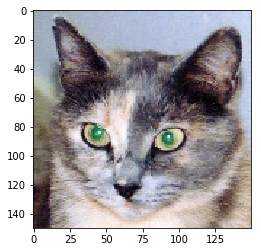

In [52]:
plt.imshow(img_tensor[0])

> In order to extract the feature maps we want to look at, we will create a Keras model
that takes batches of images as input, and outputs the activations of all convolution and
pooling layers. To do this, we will use the Keras class Model . A Model is instantiated
using two arguments: an input tensor (or list of input tensors), and an output tensor (or
list of output tensors). The resulting class is a Keras model, just like the Sequential
models that you are familiar with, mapping the specified inputs to the specified outputs.
What sets the Model class apart is that it allows for models with multiple outputs, unlike
Sequential . For more information about the Model class, see Chapter 7, Section 1.

为了提取出我们想看到的特征地图，我们需要创建一个Keras model能接受批量图像作为输入，然后输出所有卷积层和池化层的激活。这里需要用到Keras的Model类来实现。一个Model需要使用两个参数进行实例化：一个输入张量（或者输入张量的列表），和一个输出张量（或者输出张量的列表）。实例化得到的是一个Keras模型，就像Sequential模型那样。与Sequential不同的是Model类允许获得多个输出。更多关于Model类的内容请参见第7章第1节。

In [53]:
# 提取底下8层的输出:
layer_outputs = [layer.output for layer in model.layers[:8]]

# 创建一个模型接受卷积网络模型的输入，使用上面的输出:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

> When fed an image input, this model returns the values of the layer activations in the
original model. This is the first time you encounter a multi-output model in this book:
until now the models you have seen only had exactly one input and one output. In the
general case, a model could have any number of inputs and outputs. This one has one
input and 5 outputs, one output per layer activation.

当输入一张图像作为输入时，这个模型会返回原始模型中每个层的激活输出。这是本书中你首次遇到多输出模型：之前所有的模型都只接受一个输入并产生一个输出。在通用情况下，一个模型能够有任意个输入和输出。我们上面这个模型有着一个输入和5个输出，每一层的激活作为一个输出。

译者注：上文是原文直译，5个输出疑似笔误，应该是8个输出。

In [54]:
# 返回前8层的激活输出
activations = activation_model.predict(img_tensor)

> For instance, this is the activation of the first convolution layer for our cat image
input:

下面是我们输入的猫图像的第一个卷积层的激活输出：

In [55]:
first_layer_activation = activations[0]
first_layer_activation.shape

(1, 148, 148, 32)

> It’s a 148x148 feature map with 32 channels. Let’s try visualizing the 4th channel:

这是一个148x148的特征地图，有着32个通道。让我们试着可视化其中的第四个通道：

译者注：原文照译，疑似笔误，代码中应该是第5个通道。

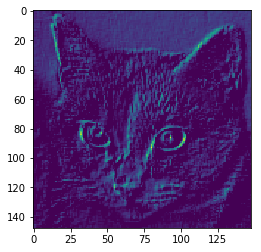

In [56]:
plt.imshow(first_layer_activation[0, :, :, 4], cmap='viridis')

> This channel appears to encode a diagonal edge detector. Let’s try the 7th
channel—but note that your own channels may vary, since the specific filters learned by
convolution layers are not deterministic.

这个通道看起来像是编码了对角线边缘。然后我们来看看第7（译者注：8）个通道 - 但是注意你实验中的通道可能会有区别，因为卷积网络学习获得的过滤器并不是确定的。

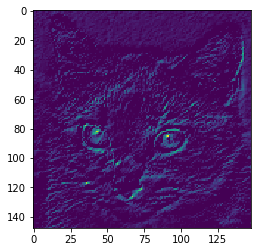

In [57]:
plt.imshow(first_layer_activation[0, :, :, 7], cmap='viridis')

> This one looks like a "bright green dot" detector, useful to encode cat eyes. At this
point, let’s go and plot a complete visualization of all the activations in the network.
We’ll extract and plot every channel in each of our 5 activation maps, and we will stack
the results in one big image tensor, with channels stacked side by side.

这个通道看起来是“亮绿点”检测器，可以用来编码猫的眼睛。现在我们来可视化所有的激活输出的可视化图像。我们会提取和绘制所有5（译者注：8）个激活地图的每个通道的图像，然后将这些结果堆叠在一个大的图像张量当中，每个通道的图像都紧挨着。

/home/wangy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


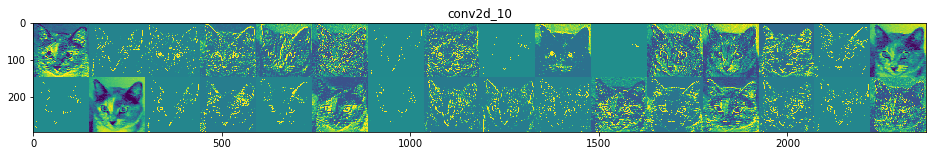

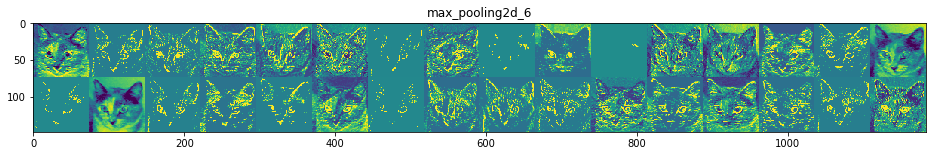

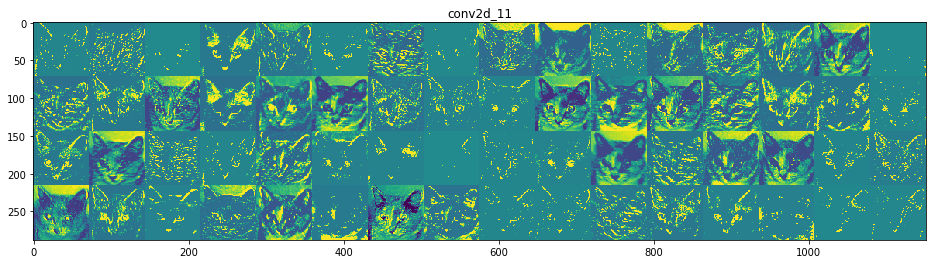

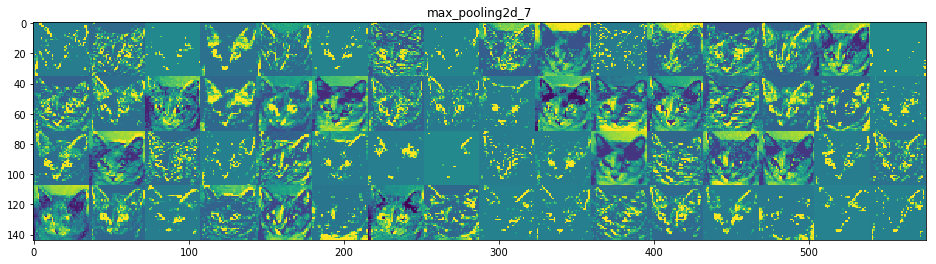

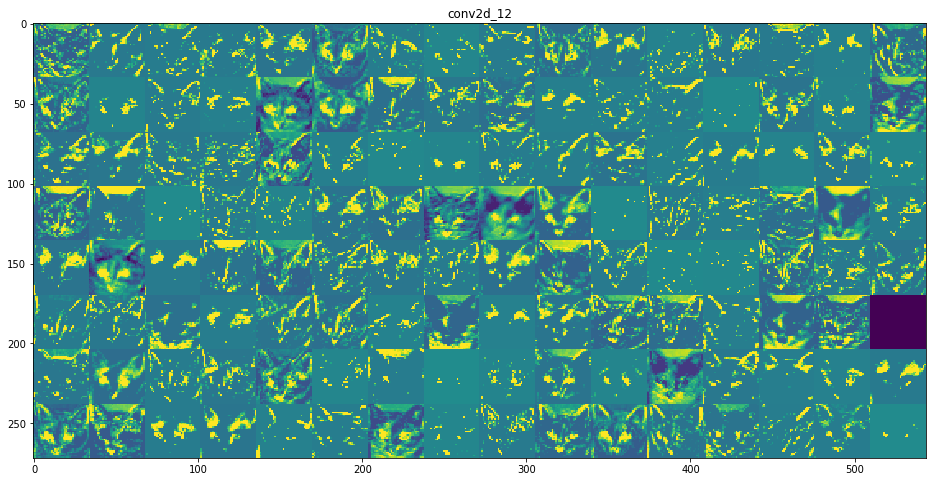

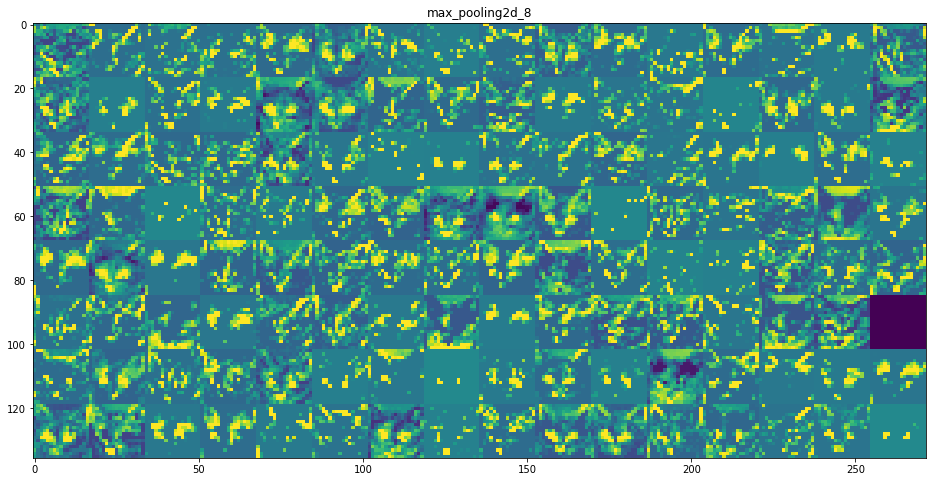

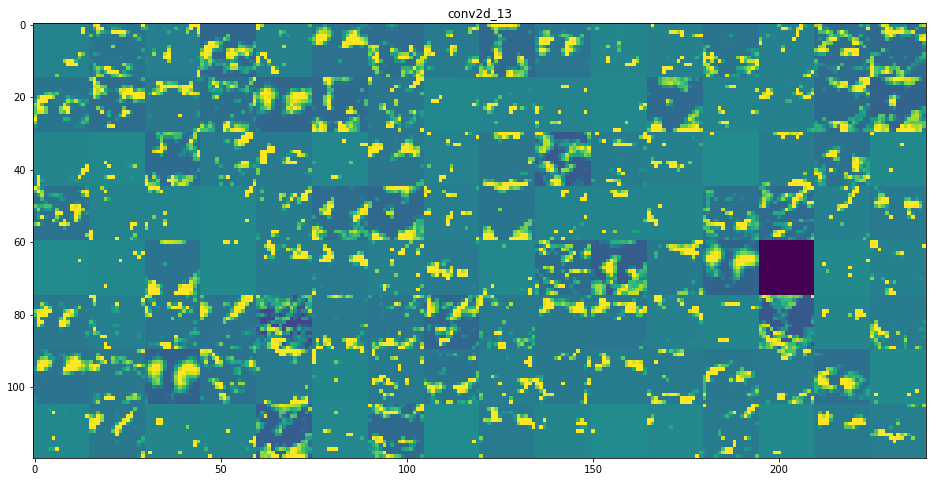

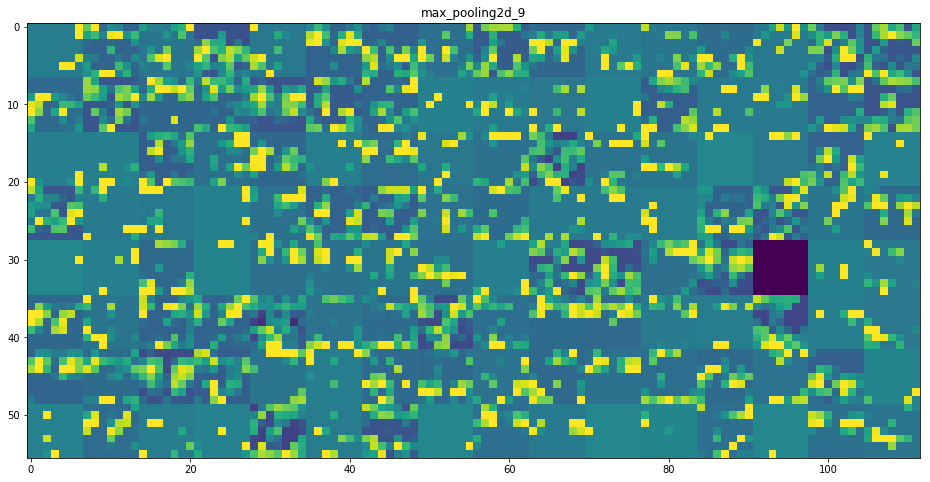

In [58]:
# 获取每一层的名称，用来展示
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# 下面来可视化所有激活地图
for layer_name, layer_activation in zip(layer_names, activations):
    # 当前层的通道数
    n_features = layer_activation.shape[-1]
    # 特征地图的形状为 (1, size, size, n_features)
    size = layer_activation.shape[1]
    # 构建一个大的Numpy张量用来堆叠所有的激活地图
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    # 每个输出都被放置在上面张量的合适位置
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            # 对激活地图进行后处理，使得可视化看起来更加清晰
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
            # 展示激活地图网格
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

> A few remarkable things to note here:

> - The first layer acts as a collection of various edge detectors. At that stage, the activations
are still retaining almost all of the information present in the initial picture.
- As we go higher-up, the activations become increasingly abstract and less visually
interpretable. They start encoding higher-level concepts such as "cat ear" or "cat eye".
Higher-up presentations carry increasingly less information about the visual contents of
the image, and increasingly more information related to the class of the image.
- The sparsity of the activations is increasing with the depth of the layer: in the first layer,
all filters are activated by the input image, but in the following layers more and more
filters are blank. This means that the pattern encoded by the filter isn’t found in the input
image.

从上面可以看到一些很值得注意的内容：

- 第一层的作用是作为不同的边缘检测器。在这个阶段，激活输出仍然包含着基本上全部原始图像中展示的视觉信息。
- 当层次越来越高时，激活输出的结果越来越抽象和不具有视觉可解释性。这些层开始编码一些高层次的概念诸如“猫耳朵”或“猫眼睛”。越高层次有着越少的原始图像视觉信息内容，但是具有越多的信息用来作为图像分类的依据。
- 激活输出的稀疏程度随着层次的升高而增加：在第一层中，所有的过滤器都是被原始图像激活的，但是后续的层次中，越来越多的过滤器变成了空白。这意味着这个过滤器编码的模型在输入图像中没有找到。

> We have just evidenced a very important universal characteristic of the
representations learned by deep neural networks: the features extracted by a layer get
increasingly abstract with the depth of the layer. The activations of layers higher-up carry
less and less information about the specific input being seen, and more and more
information about the target (in our case, the class of the image: cat or dog). A deep
neural network effectively acts as an information distillation pipeline , with raw data
going in (in our case, RBG pictures), and getting repeatedly transformed so that
irrelevant information gets filtered out (e.g. the specific visual appearance of the image)
while useful information get magnified and refined (e.g. the class of the image).

我们刚刚证明了深度神经网络学习的表现形式的一个通用特性：层次提取到的特征随着层次深度的增加而更加抽象。这些高层的激活输出携带着越来越少输入中可见的信息，但是具有越来越多的与目标相关的信息（在我们的例子中，图像的类别：猫或狗）。一个深度神经网络就是一个高效的信息蒸馏管道，输入的是原始数据（本例中的RGB图像），在管道中不断被转换使得无关信息被过滤掉（如这张特定图像的视觉内容），而同时对于目标更加有用的信息得以放大和提纯（本例中的图像类别）。

> This is analogous to the way humans and animals perceive the world: after observing
a scene for a few seconds, a human can remember which abstract objects were present in
it (e.g. bicycle, tree) but could not remember the specific appearance of these objects. In
fact, if you tried to draw a generic bicycle from mind right now, chances are you could
not get it even remotely right, even though you have seen thousands of bicycles in your
lifetime. Try it right now: this effect is absolutely real. You brain has learned to
completely abstract its visual input, to transform it into high-level visual concepts while
completely filtering out irrelevant visual details, making it tremendously difficult to
remember how things around us actually look.

这是对人类和动物感知世界的模拟：人可以在观察了一个场景几秒后，就提炼出其中的抽象对象（如自行车，树木），但是不会记忆这些目标所处的具体场景的视觉信息。事实上如果你试着从思维中绘制一辆自行车的话，很大概率你并不能绘制出每一个细节，即使你已经见过上千辆自行车的情况下。现在就尝试一下：这个情况是绝对真实的。你的大脑已经学习到了对它视觉输入的完全抽象，它会自动将无关的视觉细节过滤掉，转换并保留那些高层次的抽象概念，这会导致我们很难记得身边事物实际视觉的细节内容。

![bicycle picture](imgs/f5.28.jpg)

图5-28 左：试图从记忆中绘制自行车的情况；右：实际上具有细节的自行车图像

### 5.4.2 可视化卷积网络过滤器

译者注：本小节在tensorflow 2.0+上无法运行，因为tensorflow 2.0+使用了lazy模式。暂时未想到方法修改原书中的代码使得它们能在tensorflow 2.0+中运行。因此本小节翻译计划搁置。

### 5.4.3 可视化类别激活的热力图

译者注：本小节在tensorflow 2.0+上无法运行，因为tensorflow 2.0+使用了lazy模式。暂时未想到方法修改原书中的代码使得它们能在tensorflow 2.0+中运行。因此本小节翻译计划搁置。

## 5.5 总结：计算机视觉的深度学习

> Here’s what you should take away from this chapter:

> - Convnets are the best tool for attacking visual classification problems.
- They work by learning a hierarchy of modular patterns and concepts to represent the
visual world.
- The representations they learn are easy to inspect—they are the opposite of a black box!

> Additionally, you should have picked up practical skills:

> - You are capable of training your own convnet from scratch to solve an image
classification problem.
- You understand how to use visual data augmentation to fight overfitting.
- You know how to use a pre-trained convnet to do feature extraction and fine-tuning.
- You can generate visualizations of the filters learned by your convnets, as well as
heatmaps of class activity.

下面是你应该在本章中打包带走的内容：

- 卷积网络是解决可视化分类问题的最好工具。
- 卷积网络通过视觉世界中学习到的模块化的模式和概念来处理问题。
- 网络学习到的表现形式很容易查看，它们不是一个黑盒子！

并且你应该在本章中学习到一些实践技巧：

- 你可以从零开始搭建一个图像分类问题的卷积网络。
- 你应该知道如果使用图像数据增广技术来对抗过拟合。
- 你知道怎样使用一个预训练的卷积网络来进行特征提取和精细调参。
- 你应该了解如何可视化你的卷积网络过滤器，还有分类激活的热力地图。

<< [第四章：机器学习基础](Chapter4_Fundamentals_of_machine_learning.ipynb)|| [目录](index.md) || [第六章：文字和序列中的深度学习](Chapter6_Deep_learning_for_text_and_sequences.ipynb) >>